# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Mon Apr 10 22:59:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    10W / 170W |    678MiB / 12288MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and import required packages

In [2]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

In [3]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

fatal: destination path 'fairseq' already exists and is not an empty directory.
HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+9a1c497-cp38-cp38-linux_x86_64.whl size=2127014 sha256=8ea835833aaf266c1d9ab922ed7734470c79abd0272b59ffc0b88148f067edff
  Stored in directory: /tmp/pip-ephem-wheel-cache-trjdhx6h/wheels/7e/aa/f3/960f5478a245b4b3381019f403ebf65a2930789bfb0773aa66
Successfully built fairseq
  Attempting uninstall: fairseq
    Found existing installation: fairseq 1.0.0a0+9a1c497
    Uninstalling fairseq-1.0.0a0+9a1c497:
      Successfully uninstalled fairseq-1.0.0a0+9a1c497


In [4]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 33
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* TED2020
    - Raw: 400,726 (sentences)   
    - Processed: 394,052 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.data.tgz",
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.test.tgz"
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## Language

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq
Prepare the files in pairs for both the source and target languages. \\
In case a pair is unavailable, generate a pseudo pair to facilitate binarization.

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=70,
    #max_epoch=15,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-04-10 23:00:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-04-10 23:00:08 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 12.000 GB ; name = NVIDIA GeForce RTX 3060                 
2023-04-10 23:00:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-04-10 23:00:08 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2023-04-10 23:00:08 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-04-10 23:00:08 | INFO | hw5.seq2seq | loading data for epoch 1
2023-04-10 23:00:08 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2023-04-10 23:00:08 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2023-04-10 23:00:08 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390112 examples
2023-04-10 23:00:08 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2023-04-10 23:00:08 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2023-04-10 23:00:08 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3940 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  24,   63,    5,   90, 1323,  143,  140,  184,  281,   37,    8,   81,
         254,   11,   80,   55,   12,  376,   20,  155,   60, 1007,   98,  587,
          76,  256,    6,   98, 1465,    7,    2]),
 'target': tensor([ 162,  116, 3756,  364,  158, 3055, 2925,    9, 2547,    4,  596,  123,
        1518,  455,  667,   64,  406,  566,   74, 1908, 3790,  191,   10,    2])}
('Source: you can throw out crazy theories and not have to back it up with '
 'data or graphs or research .')
'Target: 你能拋開這些瘋狂的理論 , 不用數據圖表、或研究來支撐它 。'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
print (np.__version__)

1.23.5


In [25]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-04-10 23:00:08 | WARNING | fairseq.tasks.fairseq_task | 2,494 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1856, 2936, 918, 3863, 3373, 3540, 1246, 1791, 1790, 251]


{'id': tensor([3348]),
 'nsentences': 1,
 'ntokens': 12,
 'net_input': {'src_tokens': tensor([[ 228, 1318,    6,   30,    4,   21,  242,  629,    6,   30,  107,  694,
            478,  176,    7,    2]]),
  'src_lengths': tensor([16]),
  'prev_output_tokens': tensor([[   2,    5, 2899,  788,    4,   52,   62, 2721,  931,   50,  235,   10,
              1,    1,    1,    1]])},
 'target': tensor([[   5, 2899,  788,    4,   52,   62, 2721,  931,   50,  235,   10,    2,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [26]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

# Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [27]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [28]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

# Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [29]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [30]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [31]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    #encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    #decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [35]:
arch_args = Namespace(
    encoder_embed_dim=512,
    #encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    #encoder_ffn_embed_dim=512,
    #encoder_layers=1,
    encoder_layers=6,
    decoder_embed_dim=512,
    #decoder_embed_dim=256,
    decoder_ffn_embed_dim=2048,
    #decoder_ffn_embed_dim=1024,
    #decoder_layers=1,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    #args.encoder_attention_heads=4
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    #args.decoder_attention_heads=4
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [36]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [37]:
model = build_model(arch_args, task)
logger.info(model)

2023-04-10 23:01:03 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=51

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [38]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [39]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    lr = 0.001
    
    min = step_num * (warmup_step ** (-1.5))
    if ( (step_num ** (-0.5)) < min ):
        min = (step_num ** (-0.5))
    lr = (d_model ** (-0.5) ) * min
    
    return lr

In [40]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

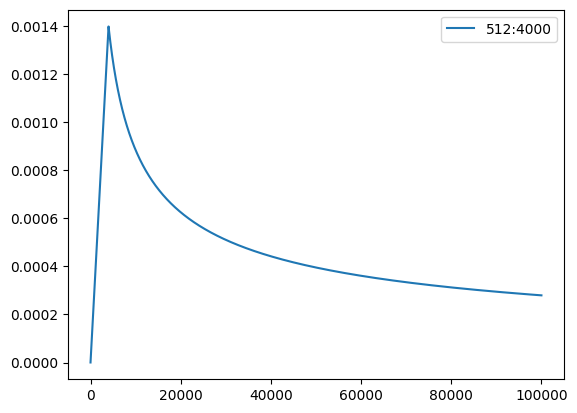

In [41]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [42]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast
gnorms = []
def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        ####################################################################
        #grad norm clipping prevents gradient exploding
        print(gnorm)
        gnorms.append(gnorm.item())
        ####################################################################
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats


In [43]:
gnorms

[]

<function matplotlib.pyplot.show(close=None, block=None)>

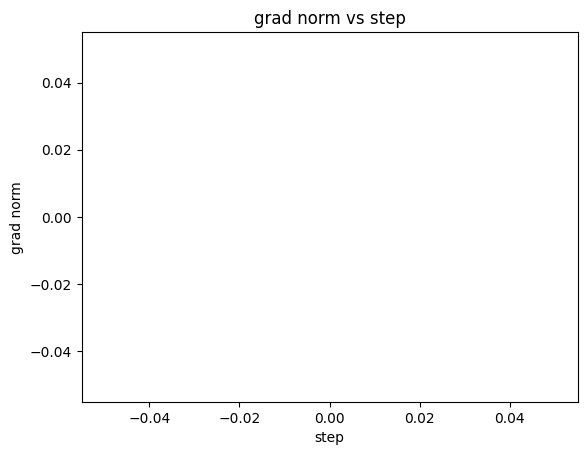

In [44]:
#ref:https://blog.csdn.net/weixin_42369818/article/details/124102920
#############################################################################
plt.plot(range(1, len(gnorms)+1), gnorms)
plt.plot(range(1, len(gnorms)+1), [config.clip_norm]* len(gnorms), "-")
plt.title('grad norm vs step')
plt.xlabel("step")
plt.ylabel("grad norm")
plt.show
##############################################################################

Size of pos_emb torch.Size([1026, 512])


<Figure size 800x800 with 0 Axes>

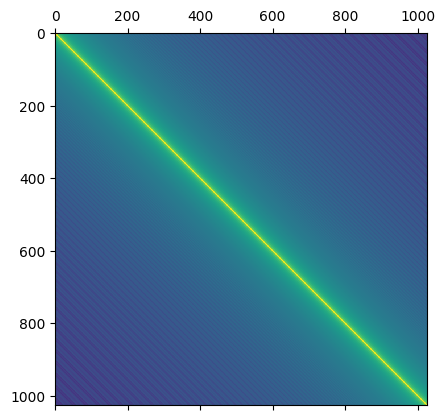

In [45]:
#ref:https://blog.csdn.net/weixin_42369818/article/details/124102920
######################################################################################
from torch.nn.functional import cosine_similarity as cs
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
print('Size of pos_emb', pos_emb.size())
ret = cs(pos_emb.unsqueeze(1), pos_emb, dim=2)
plt.figure(figsize = (8, 8))
plt.matshow(ret)
plt.show()
#######################################################################################

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [46]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [47]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [48]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [49]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [50]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-04-10 23:01:34 | INFO | hw5.seq2seq | task: TranslationTask
2023-04-10 23:01:34 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2023-04-10 23:01:34 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2023-04-10 23:01:34 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-04-10 23:01:34 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-04-10 23:01:34 | INFO | hw5.seq2seq | num. model params: 46,026,752 (num. trained: 46,026,752)
2023-04-10 23:01:34 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [51]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
#try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-04-10 23:01:36 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326653]


train epoch 1:   0%|          | 0/790 [00:00<?, ?it/s]

/home/ccpy-ubuntu20045/anaconda3/envs/teat/lib/python3.8/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(1.7553, device='cuda:0')
tensor(1.6085, device='cuda:0')
tensor(1.5473, device='cuda:0')
tensor(1.6005, device='cuda:0')
tensor(1.6929, device='cuda:0')
tensor(1.4958, device='cuda:0')
tensor(1.8869, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(1.9141, device='cuda:0')
tensor(2.1934, device='cuda:0')
tensor(1.6678, device='cuda:0')
tensor(1.5966, device='cuda:0')
tensor(1.7552, device='cuda:0')
tensor(1.6555, device='cuda:0')
tensor(1.7119, device='cuda:0')
tensor(1.6954, device='cuda:0')
tensor(1.7561, device='cuda:0')
tensor(1.6623, device='cuda:0')
tensor(1.6586, device='cuda:0')
tensor(1.5432, device='cuda:0')
tensor(1.5560, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(1.685

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:10:33 | INFO | hw5.seq2seq | example source: and so games , for a change , it changes how we see topics , it changes our perceptions about those people in topics , and it changes ourselves .
2023-04-10 23:10:33 | INFO | hw5.seq2seq | example hypothesis: 所以 , 問題是 , 我們知道 , 我們能改變的改變 。
2023-04-10 23:10:33 | INFO | hw5.seq2seq | example reference: 所以遊戲能夠改變我們對事物的看法改變我們對人們和議題的觀感並且改變我們本身
2023-04-10 23:10:33 | INFO | hw5.seq2seq | validation loss:	5.4915
2023-04-10 23:10:33 | INFO | hw5.seq2seq | BLEU = 3.39 26.4/7.6/2.4/0.8 (BP = 0.768 ratio = 0.791 hyp_len = 87359 ref_len = 110430)
2023-04-10 23:10:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint1.pt
2023-04-10 23:10:36 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.6193, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.7708, device='cuda:0')
tensor(0.5845, device='cuda:0')
tensor(0.4899, device='cuda:0')
tensor(0.6468, device='cuda:0')
tensor(0.5113, device='cuda:0')
tensor(0.6159, device='cuda:0')
tensor(0.5187, device='cuda:0')
tensor(0.5329, device='cuda:0')
tensor(0.8033, device='cuda:0')
tensor(0.4410, device='cuda:0')
tensor(0.5981, device='cuda:0')
tensor(0.4964, device='cuda:0')
tensor(1.1188, device='cuda:0')
tensor(0.7793, device='cuda:0')
tensor(0.7231, device='cuda:0')
tensor(0.5138, device='cuda:0')
tensor(0.7115, device='cuda:0')
tensor(0.6699, device='cuda:0')
tensor(0.4926, device='cuda:0')
tensor(0.6489, device='cuda:0')
tensor(0.5531, device='cuda:0')
tensor(0.5388, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:17:53 | INFO | hw5.seq2seq | example source: if someone was to throw an egg at the sistine chapel , we'd all go crazy .
2023-04-10 23:17:53 | INFO | hw5.seq2seq | example hypothesis: 假如 , 阿富汗人在阿富汗 , 我們都去找一個瘋狂的瘋狂 。
2023-04-10 23:17:53 | INFO | hw5.seq2seq | example reference: 如果有人扔一個雞蛋在西斯廷教堂 , 我們都會抓狂 。
2023-04-10 23:17:53 | INFO | hw5.seq2seq | validation loss:	4.6061
2023-04-10 23:17:53 | INFO | hw5.seq2seq | BLEU = 11.21 37.4/16.0/7.4/3.6 (BP = 1.000 ratio = 1.044 hyp_len = 115331 ref_len = 110430)
2023-04-10 23:17:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint2.pt
2023-04-10 23:17:55 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.4895, device='cuda:0')
tensor(0.5972, device='cuda:0')
tensor(0.5583, device='cuda:0')
tensor(0.4597, device='cuda:0')
tensor(0.6718, device='cuda:0')
tensor(0.5876, device='cuda:0')
tensor(0.5009, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.5325, device='cuda:0')
tensor(0.4833, device='cuda:0')
tensor(0.5641, device='cuda:0')
tensor(0.6490, device='cuda:0')
tensor(0.4804, device='cuda:0')
tensor(0.4897, device='cuda:0')
tensor(0.6709, device='cuda:0')
tensor(0.7861, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.5910, device='cuda:0')
tensor(0.5697, device='cuda:0')
tensor(0.4806, device='cuda:0')
tensor(0.5077, device='cuda:0')
tensor(0.4696, device='cuda:0')
tensor(0.4358, device='cuda:0')
tensor(0.7834, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:25:08 | INFO | hw5.seq2seq | example source: paradoxically , it was god who created hell as a place to store evil .
2023-04-10 23:25:08 | INFO | hw5.seq2seq | example hypothesis: 矛盾的是 , 上帝是創造一個地方的神 。
2023-04-10 23:25:08 | INFO | hw5.seq2seq | example reference: 矛盾的是 , 是上帝造出了惡的容身之處---地獄 。
2023-04-10 23:25:08 | INFO | hw5.seq2seq | validation loss:	4.1484
2023-04-10 23:25:08 | INFO | hw5.seq2seq | BLEU = 15.70 49.8/24.4/12.8/7.1 (BP = 0.862 ratio = 0.871 hyp_len = 96131 ref_len = 110430)
2023-04-10 23:25:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint3.pt
2023-04-10 23:25:10 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.4620, device='cuda:0')
tensor(0.5396, device='cuda:0')
tensor(0.4978, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.5457, device='cuda:0')
tensor(0.4160, device='cuda:0')
tensor(0.4607, device='cuda:0')
tensor(0.3847, device='cuda:0')
tensor(0.3817, device='cuda:0')
tensor(0.3907, device='cuda:0')
tensor(0.5081, device='cuda:0')
tensor(0.6814, device='cuda:0')
tensor(0.4302, device='cuda:0')
tensor(0.6713, device='cuda:0')
tensor(0.6070, device='cuda:0')
tensor(0.7256, device='cuda:0')
tensor(1.1060, device='cuda:0')
tensor(0.6250, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.7692, device='cuda:0')
tensor(0.5061, device='cuda:0')
tensor(0.5073, device='cuda:0')
tensor(0.4712, device='cuda:0')
tensor(0.

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:32:20 | INFO | hw5.seq2seq | example source: ninetyfive percent of them just stopped .
2023-04-10 23:32:20 | INFO | hw5.seq2seq | example hypothesis: 95%的人只會停下來 。
2023-04-10 23:32:20 | INFO | hw5.seq2seq | example reference: 百分之九十五的人直接停止使用
2023-04-10 23:32:20 | INFO | hw5.seq2seq | validation loss:	4.0569
2023-04-10 23:32:20 | INFO | hw5.seq2seq | BLEU = 16.42 53.5/27.2/14.8/8.6 (BP = 0.791 ratio = 0.810 hyp_len = 89461 ref_len = 110430)
2023-04-10 23:32:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint4.pt
2023-04-10 23:32:22 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.5499, device='cuda:0')
tensor(0.5217, device='cuda:0')
tensor(0.5662, device='cuda:0')
tensor(0.4097, device='cuda:0')
tensor(0.4197, device='cuda:0')
tensor(0.4162, device='cuda:0')
tensor(0.4502, device='cuda:0')
tensor(0.4859, device='cuda:0')
tensor(0.7497, device='cuda:0')
tensor(0.4286, device='cuda:0')
tensor(0.4903, device='cuda:0')
tensor(0.5116, device='cuda:0')
tensor(0.4052, device='cuda:0')
tensor(0.4947, device='cuda:0')
tensor(0.3849, device='cuda:0')
tensor(0.4933, device='cuda:0')
tensor(0.3826, device='cuda:0')
tensor(0.4176, device='cuda:0')
tensor(0.4743, device='cuda:0')
tensor(0.4045, device='cuda:0')
tensor(0.4517, device='cuda:0')
tensor(0.3967, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:39:38 | INFO | hw5.seq2seq | example source: when you run a program , your operating system allocates area within the shortterm memory for performing those instructions .
2023-04-10 23:39:38 | INFO | hw5.seq2seq | example hypothesis: 當你跑一個程式時 , 你的運作系統會在短期記憶中出現在短期記憶中 。
2023-04-10 23:39:38 | INFO | hw5.seq2seq | example reference: 當你執行程式時 , 作業作系統會分配短暫記憶體以便執行程式指令 。
2023-04-10 23:39:38 | INFO | hw5.seq2seq | validation loss:	3.8053
2023-04-10 23:39:38 | INFO | hw5.seq2seq | BLEU = 19.93 52.7/27.3/15.1/8.8 (BP = 0.952 ratio = 0.954 hyp_len = 105300 ref_len = 110430)
2023-04-10 23:39:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint5.pt
2023-04-10 23:39:41 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3116, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.4120, device='cuda:0')
tensor(0.3980, device='cuda:0')
tensor(0.3660, device='cuda:0')
tensor(0.3306, device='cuda:0')
tensor(0.5393, device='cuda:0')
tensor(0.3488, device='cuda:0')
tensor(0.3653, device='cuda:0')
tensor(0.4190, device='cuda:0')
tensor(0.3945, device='cuda:0')
tensor(0.4130, device='cuda:0')
tensor(0.5025, device='cuda:0')
tensor(0.3818, device='cuda:0')
tensor(0.3831, device='cuda:0')
tensor(0.3670, device='cuda:0')
tensor(0.3654, device='cuda:0')
tensor(0.3428, device='cuda:0')
tensor(0.3302, device='cuda:0')
tensor(0.3598, device='cuda:0')
tensor(0.6248, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3680, device='cuda:0')
tensor(0.

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:46:56 | INFO | hw5.seq2seq | example source: as we have hot blood running through our veins and arteries , so , too , the earth has hot water running through its cracks and faults .
2023-04-10 23:46:56 | INFO | hw5.seq2seq | example hypothesis: 我們有熱血流過我們的血液流過我們的血管和血液 , 所以 , 地球也有熱水 , 穿過它的裂縫和流動 。
2023-04-10 23:46:56 | INFO | hw5.seq2seq | example reference: 就如我們身體𥚃有熱騰騰的血液經過靜脈和動脈 , 同樣地 , 地球也有熱流穿過它的裂縫和斷層 。
2023-04-10 23:46:56 | INFO | hw5.seq2seq | validation loss:	3.6643
2023-04-10 23:46:56 | INFO | hw5.seq2seq | BLEU = 21.11 55.1/29.7/17.0/10.3 (BP = 0.914 ratio = 0.917 hyp_len = 101286 ref_len = 110430)
2023-04-10 23:46:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint6.pt
2023-04-10 23:46:59 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2936, device='cuda:0')
tensor(0.2949, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2952, device='cuda:0')
tensor(0.3815, device='cuda:0')
tensor(0.2885, device='cuda:0')
tensor(0.3429, device='cuda:0')
tensor(0.3600, device='cuda:0')
tensor(0.2634, device='cuda:0')
tensor(0.3183, device='cuda:0')
tensor(0.4183, device='cuda:0')
tensor(0.3458, device='cuda:0')
tensor(0.2811, device='cuda:0')
tensor(0.3853, device='cuda:0')
tensor(0.2991, device='cuda:0')
tensor(0.3162, device='cuda:0')
tensor(0.3145, device='cuda:0')
tensor(0.3308, device='cuda:0')
tensor(0.3818, device='cuda:0')
tensor(0.3280, device='cuda:0')
tensor(0.3278, device='cuda:0')
tensor(0.3843, device='cuda:0')
tensor(0.3436, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-10 23:53:54 | INFO | hw5.seq2seq | example source: and i couldn't hear this sound .
2023-04-10 23:53:54 | INFO | hw5.seq2seq | example hypothesis: 我聽不到這個聲音 。
2023-04-10 23:53:54 | INFO | hw5.seq2seq | example reference: 但我聽不到聲音 。
2023-04-10 23:53:54 | INFO | hw5.seq2seq | validation loss:	3.5669
2023-04-10 23:53:54 | INFO | hw5.seq2seq | BLEU = 21.70 57.3/31.4/18.1/11.0 (BP = 0.886 ratio = 0.892 hyp_len = 98499 ref_len = 110430)
2023-04-10 23:53:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint7.pt
2023-04-10 23:53:57 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3599, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3715, device='cuda:0')
tensor(0.3087, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3002, device='cuda:0')
tensor(0.3038, device='cuda:0')
tensor(0.3507, device='cuda:0')
tensor(0.3840, device='cuda:0')
tensor(0.4796, device='cuda:0')
tensor(0.3009, device='cuda:0')
tensor(0.3245, device='cuda:0')
tensor(0.2729, device='cuda:0')
tensor(0.3905, device='cuda:0')
tensor(0.4031, device='cuda:0')
tensor(0.3433, device='cuda:0')
tensor(0.2741, device='cuda:0')
tensor(0.3283, device='cuda:0')
tensor(0.3243, device='cuda:0')
tensor(0.3132, device='cuda:0')
tensor(0.3495, device='cuda:0')
tensor(0.3720, device='cuda:0')
tensor(0.507

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:01:04 | INFO | hw5.seq2seq | example source: by 1960 we had telephone bills , bank statements were being produced by computers .
2023-04-11 00:01:04 | INFO | hw5.seq2seq | example hypothesis: 到了1960年 , 我們有手機帳單 , 銀行宣言被電腦生產出來 。
2023-04-11 00:01:04 | INFO | hw5.seq2seq | example reference: 到了1960年 , 我們的電話和銀行帳單都交由電腦處理
2023-04-11 00:01:04 | INFO | hw5.seq2seq | validation loss:	3.5087
2023-04-11 00:01:04 | INFO | hw5.seq2seq | BLEU = 22.97 57.9/32.1/18.9/11.7 (BP = 0.908 ratio = 0.912 hyp_len = 100728 ref_len = 110430)
2023-04-11 00:01:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint8.pt
2023-04-11 00:01:07 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2772, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.4250, device='cuda:0')
tensor(0.2630, device='cuda:0')
tensor(0.3093, device='cuda:0')
tensor(0.2595, device='cuda:0')
tensor(0.3085, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2848, device='cuda:0')
tensor(0.2920, device='cuda:0')
tensor(0.2734, device='cuda:0')
tensor(0.2604, device='cuda:0')
tensor(0.2806, device='cuda:0')
tensor(0.2946, device='cuda:0')
tensor(0.6442, device='cuda:0')
tensor(0.2557, device='cuda:0')
tensor(0.3314, device='cuda:0')
tensor(0.2720, device='cuda:0')
tensor(0.2932, device='cuda:0')
tensor(0.3332, device='cuda:0')
tensor(0.3275, device='cuda:0')
tensor(0.3914, device='cuda:0')
tensor(0.2525, device='cuda:0')
tensor(0.3715, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:08:03 | INFO | hw5.seq2seq | example source: no , i don't do that .
2023-04-11 00:08:03 | INFO | hw5.seq2seq | example hypothesis: 不 , 我沒有這麼做 。
2023-04-11 00:08:03 | INFO | hw5.seq2seq | example reference: 不 , 我不做那種事 。
2023-04-11 00:08:03 | INFO | hw5.seq2seq | validation loss:	3.4444
2023-04-11 00:08:03 | INFO | hw5.seq2seq | BLEU = 23.64 58.6/32.7/19.3/12.0 (BP = 0.916 ratio = 0.920 hyp_len = 101551 ref_len = 110430)
2023-04-11 00:08:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint9.pt
2023-04-11 00:08:06 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2981, device='cuda:0')
tensor(0.2446, device='cuda:0')
tensor(0.2940, device='cuda:0')
tensor(0.2357, device='cuda:0')
tensor(0.2373, device='cuda:0')
tensor(0.2448, device='cuda:0')
tensor(0.2459, device='cuda:0')
tensor(0.2508, device='cuda:0')
tensor(0.2895, device='cuda:0')
tensor(0.2306, device='cuda:0')
tensor(0.2643, device='cuda:0')
tensor(0.3091, device='cuda:0')
tensor(0.2429, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2299, device='cuda:0')
tensor(0.2599, device='cuda:0')
tensor(0.2311, device='cuda:0')
tensor(0.2583, device='cuda:0')
tensor(0.2530, device='cuda:0')
tensor(0.3263, device='cuda:0')
tensor(0.2689, device='cuda:0')
tensor(0.2916, device='cuda:0')
tensor(0.2323, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:15:07 | INFO | hw5.seq2seq | example source: if at least nine of you guess correctly , you'll all be spared .
2023-04-11 00:15:07 | INFO | hw5.seq2seq | example hypothesis: 如果至少有九個人猜得正確 , 大家都會被加速 。
2023-04-11 00:15:07 | INFO | hw5.seq2seq | example reference: 如果你們之中 , 有九位以上回答正確 , 所有人就能被釋放 。
2023-04-11 00:15:07 | INFO | hw5.seq2seq | validation loss:	3.3963
2023-04-11 00:15:07 | INFO | hw5.seq2seq | BLEU = 24.32 56.6/31.5/18.6/11.6 (BP = 0.977 ratio = 0.977 hyp_len = 107886 ref_len = 110430)
2023-04-11 00:15:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint10.pt
2023-04-11 00:15:09 | INFO | hw5.seq2seq | end of epoch 10


train epoch 11:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2660, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2690, device='cuda:0')
tensor(0.2251, device='cuda:0')
tensor(0.3203, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(0.3014, device='cuda:0')
tensor(0.2699, device='cuda:0')
tensor(0.2369, device='cuda:0')
tensor(0.2516, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.2726, device='cuda:0')
tensor(0.2564, device='cuda:0')
tensor(0.2425, device='cuda:0')
tensor(0.2147, device='cuda:0')
tensor(0.2581, device='cuda:0')
tensor(0.2494, device='cuda:0')
tensor(0.3681, device='cuda:0')
tensor(0.2468, device='cuda:0')
tensor(0.2208, device='cuda:0')
tensor(0.2775, device='cuda:0')
tensor(0.3323, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:22:18 | INFO | hw5.seq2seq | example source: the first secret of shame for a woman for being a woman , " a little break . "
2023-04-11 00:22:18 | INFO | hw5.seq2seq | example hypothesis: 身為女性的羞恥的第一個秘密是 「 休息一下 」 。
2023-04-11 00:22:18 | INFO | hw5.seq2seq | example reference: 身為女人 , 第一個恥辱的秘密就是 「 休息一陣子 」
2023-04-11 00:22:18 | INFO | hw5.seq2seq | validation loss:	3.3711
2023-04-11 00:22:18 | INFO | hw5.seq2seq | BLEU = 24.93 57.5/32.4/19.3/12.1 (BP = 0.971 ratio = 0.971 hyp_len = 107239 ref_len = 110430)
2023-04-11 00:22:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint11.pt
2023-04-11 00:22:21 | INFO | hw5.seq2seq | end of epoch 11


train epoch 12:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2268, device='cuda:0')
tensor(0.2169, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2540, device='cuda:0')
tensor(0.3028, device='cuda:0')
tensor(0.2195, device='cuda:0')
tensor(0.2690, device='cuda:0')
tensor(0.2561, device='cuda:0')
tensor(0.2214, device='cuda:0')
tensor(0.3462, device='cuda:0')
tensor(0.5380, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2306, device='cuda:0')
tensor(0.2968, device='cuda:0')
tensor(0.3229, device='cuda:0')
tensor(0.4371, device='cuda:0')
tensor(0.2812, device='cuda:0')
tensor(0.3175, device='cuda:0')
tensor(0.2739, device='cuda:0')
tensor(0.2457, device='cuda:0')
tensor(0.2547, device='cuda:0')
tensor(0.2858, device='cuda:0')
tensor(0.2722, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:29:34 | INFO | hw5.seq2seq | example source: powerpoint has this built into every copy of it that's shipped .
2023-04-11 00:29:34 | INFO | hw5.seq2seq | example hypothesis: powerpoint將它建置在每一本被運送的複製品中 。
2023-04-11 00:29:34 | INFO | hw5.seq2seq | example reference: 每一套powerpoint軟體裡
2023-04-11 00:29:34 | INFO | hw5.seq2seq | validation loss:	3.3494
2023-04-11 00:29:34 | INFO | hw5.seq2seq | BLEU = 25.00 58.0/32.8/19.6/12.3 (BP = 0.960 ratio = 0.961 hyp_len = 106147 ref_len = 110430)
2023-04-11 00:29:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint12.pt
2023-04-11 00:29:36 | INFO | hw5.seq2seq | end of epoch 12


train epoch 13:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2731, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(0.2257, device='cuda:0')
tensor(0.2687, device='cuda:0')
tensor(0.2525, device='cuda:0')
tensor(0.2276, device='cuda:0')
tensor(0.2297, device='cuda:0')
tensor(0.2655, device='cuda:0')
tensor(0.2533, device='cuda:0')
tensor(0.2700, device='cuda:0')
tensor(0.2038, device='cuda:0')
tensor(0.3052, device='cuda:0')
tensor(0.2808, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.3336, device='cuda:0')
tensor(0.2318, device='cuda:0')
tensor(0.2872, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3194, device='cuda:0')
tensor(0.2099, device='cuda:0')
tensor(0.2200, device='cuda:0')
tensor(0.2127, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:36:40 | INFO | hw5.seq2seq | example source: when you govern through fear and you govern through cruelty , it just doesn't work .
2023-04-11 00:36:40 | INFO | hw5.seq2seq | example hypothesis: 當你用恐懼來治理 , 用殘酷的方式治理 , 它就沒有用 。
2023-04-11 00:36:40 | INFO | hw5.seq2seq | example reference: 透過恐懼 , 透過殘忍來治理國家 , 這是行不通的 。
2023-04-11 00:36:40 | INFO | hw5.seq2seq | validation loss:	3.3331
2023-04-11 00:36:40 | INFO | hw5.seq2seq | BLEU = 24.72 58.8/33.5/20.0/12.6 (BP = 0.931 ratio = 0.933 hyp_len = 103034 ref_len = 110430)
2023-04-11 00:36:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint13.pt
2023-04-11 00:36:42 | INFO | hw5.seq2seq | end of epoch 13


train epoch 14:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2619, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2412, device='cuda:0')
tensor(0.2344, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2503, device='cuda:0')
tensor(0.2353, device='cuda:0')
tensor(0.3084, device='cuda:0')
tensor(0.2213, device='cuda:0')
tensor(0.2661, device='cuda:0')
tensor(0.2559, device='cuda:0')
tensor(0.2953, device='cuda:0')
tensor(0.2139, device='cuda:0')
tensor(0.2336, device='cuda:0')
tensor(0.2246, device='cuda:0')
tensor(0.2239, device='cuda:0')
tensor(0.2176, device='cuda:0')
tensor(0.2861, device='cuda:0')
tensor(0.2289, device='cuda:0')
tensor(0.2264, device='cuda:0')
tensor(0.2103, device='cuda:0')
tensor(0.3962, device='cuda:0')
tensor(0.3111, device='cuda:0')
tensor(0.2578, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:43:28 | INFO | hw5.seq2seq | example source: i hit " refresh . "
2023-04-11 00:43:28 | INFO | hw5.seq2seq | example hypothesis: 我撞到 「 新鮮 」 。
2023-04-11 00:43:28 | INFO | hw5.seq2seq | example reference: 我再按 「 網頁刷新 」 。
2023-04-11 00:43:28 | INFO | hw5.seq2seq | validation loss:	3.3262
2023-04-11 00:43:28 | INFO | hw5.seq2seq | BLEU = 25.06 59.1/33.6/20.1/12.7 (BP = 0.940 ratio = 0.941 hyp_len = 103944 ref_len = 110430)
2023-04-11 00:43:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint14.pt
2023-04-11 00:43:31 | INFO | hw5.seq2seq | end of epoch 14


train epoch 15:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2755, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2356, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2232, device='cuda:0')
tensor(0.2666, device='cuda:0')
tensor(0.3340, device='cuda:0')
tensor(0.2639, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.2460, device='cuda:0')
tensor(0.2266, device='cuda:0')
tensor(0.2666, device='cuda:0')
tensor(0.2293, device='cuda:0')
tensor(0.2196, device='cuda:0')
tensor(0.2620, device='cuda:0')
tensor(0.2878, device='cuda:0')
tensor(0.2240, device='cuda:0')
tensor(0.2643, device='cuda:0')
tensor(0.2447, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(0.2353, device='cuda:0')
tensor(0.2480, device='cuda:0')
tensor(0.2839, device='cuda:0')
tensor(0.2372, device='cuda:0')
tensor(0.2265, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:50:16 | INFO | hw5.seq2seq | example source: and so it's the pursuit of better things , easily shared .
2023-04-11 00:50:16 | INFO | hw5.seq2seq | example hypothesis: 所以 , 這是追求更好的東西 , 很容易就共享 。
2023-04-11 00:50:16 | INFO | hw5.seq2seq | example reference: 這就是一種追求:要讓好東西更容易被分享 。
2023-04-11 00:50:16 | INFO | hw5.seq2seq | validation loss:	3.2983
2023-04-11 00:50:16 | INFO | hw5.seq2seq | BLEU = 25.41 59.3/34.1/20.6/13.1 (BP = 0.936 ratio = 0.938 hyp_len = 103536 ref_len = 110430)
2023-04-11 00:50:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint15.pt
2023-04-11 00:50:19 | INFO | hw5.seq2seq | end of epoch 15


train epoch 16:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3072, device='cuda:0')
tensor(0.2556, device='cuda:0')
tensor(0.2512, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2217, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(0.2194, device='cuda:0')
tensor(0.1858, device='cuda:0')
tensor(0.2263, device='cuda:0')
tensor(0.2210, device='cuda:0')
tensor(0.3434, device='cuda:0')
tensor(0.3177, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2609, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.2401, device='cuda:0')
tensor(0.2537, device='cuda:0')
tensor(0.2821, device='cuda:0')
tensor(0.2112, device='cuda:0')
tensor(0.2259, device='cuda:0')
tensor(0.2474, device='cuda:0')
tensor(0.2852, device='cuda:0')
tensor(0.2474, device='cuda:0')
tensor(0.2532, device='cuda:0')
tensor(inf, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 00:57:17 | INFO | hw5.seq2seq | example source: and i want you to think about the community that you want to be part of creating .
2023-04-11 00:57:17 | INFO | hw5.seq2seq | example hypothesis: 我希望各位能想想你想要成為創造社區的一份子 。
2023-04-11 00:57:17 | INFO | hw5.seq2seq | example reference: 我希望你想像一下你希望參與創造的那個社群 。
2023-04-11 00:57:17 | INFO | hw5.seq2seq | validation loss:	3.2929
2023-04-11 00:57:17 | INFO | hw5.seq2seq | BLEU = 25.93 58.0/33.1/20.0/12.6 (BP = 0.983 ratio = 0.983 hyp_len = 108516 ref_len = 110430)
2023-04-11 00:57:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint16.pt
2023-04-11 00:57:20 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2278, device='cuda:0')
tensor(0.2430, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2597, device='cuda:0')
tensor(0.2385, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2168, device='cuda:0')
tensor(0.2385, device='cuda:0')
tensor(0.2081, device='cuda:0')
tensor(0.2550, device='cuda:0')
tensor(0.2547, device='cuda:0')
tensor(0.2440, device='cuda:0')
tensor(0.2823, device='cuda:0')
tensor(0.2524, device='cuda:0')
tensor(0.2516, device='cuda:0')
tensor(0.2397, device='cuda:0')
tensor(0.2558, device='cuda:0')
tensor(0.2388, device='cuda:0')
tensor(0.2286, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(0.2564, device='cuda:0')
tensor(0.2346, device='cuda:0')
tensor(0.3116, device='cuda:0')
tensor(0.2314, device='cuda:0')
tensor(0.2058, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:04:27 | INFO | hw5.seq2seq | example source: instead , the west chose to go to sleep .
2023-04-11 01:04:27 | INFO | hw5.seq2seq | example hypothesis: 相反地 , 西方選擇去睡覺 。
2023-04-11 01:04:27 | INFO | hw5.seq2seq | example reference: 然而相反地 , 西方選擇沈睡 。
2023-04-11 01:04:27 | INFO | hw5.seq2seq | validation loss:	3.2869
2023-04-11 01:04:27 | INFO | hw5.seq2seq | BLEU = 26.01 58.7/33.6/20.3/13.0 (BP = 0.968 ratio = 0.969 hyp_len = 106964 ref_len = 110430)
2023-04-11 01:04:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint17.pt
2023-04-11 01:04:29 | INFO | hw5.seq2seq | end of epoch 17


train epoch 18:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2394, device='cuda:0')
tensor(0.2130, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2665, device='cuda:0')
tensor(0.2352, device='cuda:0')
tensor(0.2841, device='cuda:0')
tensor(0.2558, device='cuda:0')
tensor(0.2490, device='cuda:0')
tensor(0.2149, device='cuda:0')
tensor(0.2055, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2451, device='cuda:0')
tensor(0.2606, device='cuda:0')
tensor(0.2258, device='cuda:0')
tensor(0.2387, device='cuda:0')
tensor(0.2498, device='cuda:0')
tensor(0.2501, device='cuda:0')
tensor(0.2520, device='cuda:0')
tensor(0.2781, device='cuda:0')
tensor(0.2603, device='cuda:0')
tensor(0.2997, device='cuda:0')
tensor(0.3052, device='cuda:0')
tensor(0.2929, device='cuda:0')
tensor(0.2126, device='cuda:0')
tensor(0.2238, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:11:37 | INFO | hw5.seq2seq | example source: and the fact is , millions is a gross estimate , because we don't really know how many kids die each year of this .
2023-04-11 01:11:37 | INFO | hw5.seq2seq | example hypothesis: 事實是 , 數百萬人是很噁心的估計 , 因為我們並不知道每年有多少孩子死亡 。
2023-04-11 01:11:37 | INFO | hw5.seq2seq | example reference: 而且事實是 , 數百萬只是一個粗略的估計 , 因為我們真的不知道每年究竟有多少孩子死於這些疾病 。
2023-04-11 01:11:37 | INFO | hw5.seq2seq | validation loss:	3.2777
2023-04-11 01:11:37 | INFO | hw5.seq2seq | BLEU = 26.15 58.3/33.4/20.2/12.9 (BP = 0.980 ratio = 0.980 hyp_len = 108221 ref_len = 110430)
2023-04-11 01:11:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint18.pt
2023-04-11 01:11:39 | INFO | hw5.seq2seq | end of epoch 18


train epoch 19:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.1967, device='cuda:0')
tensor(0.2374, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(0.2581, device='cuda:0')
tensor(0.2103, device='cuda:0')
tensor(0.2845, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(0.2697, device='cuda:0')
tensor(0.2675, device='cuda:0')
tensor(0.2261, device='cuda:0')
tensor(0.2151, device='cuda:0')
tensor(0.2473, device='cuda:0')
tensor(0.1993, device='cuda:0')
tensor(0.2336, device='cuda:0')
tensor(0.2023, device='cuda:0')
tensor(0.2759, device='cuda:0')
tensor(0.2317, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2031, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3194, device='cuda:0')
tensor(0.3150, device='cuda:0')
tensor(0.2328, device='cuda:0')
tensor(0.2721, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:18:33 | INFO | hw5.seq2seq | example source: secondly , make it clear from the beginning that either you have no money at all or that you would rather spend money with your attorney fighting the troll than actually giving them the money .
2023-04-11 01:18:33 | INFO | hw5.seq2seq | example hypothesis: 第二 , 要從一開始就清楚地說 , 要麼你沒有錢 , 要麼你寧願花錢和你的律師對抗軍隊 , 而不是給他們錢 。
2023-04-11 01:18:33 | INFO | hw5.seq2seq | example reference: 第二一開始就講清楚說你根本沒半毛錢或是說你寧願花錢告垮專利蟑螂也不願把錢給他們
2023-04-11 01:18:33 | INFO | hw5.seq2seq | validation loss:	3.2708
2023-04-11 01:18:33 | INFO | hw5.seq2seq | BLEU = 26.22 58.8/33.7/20.4/13.0 (BP = 0.973 ratio = 0.973 hyp_len = 107500 ref_len = 110430)
2023-04-11 01:18:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint19.pt
2023-04-11 01:18:36 | INFO | hw5.seq2seq | end of epoch 19


train epoch 20:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2543, device='cuda:0')
tensor(0.2608, device='cuda:0')
tensor(0.2426, device='cuda:0')
tensor(0.2218, device='cuda:0')
tensor(0.2832, device='cuda:0')
tensor(0.1985, device='cuda:0')
tensor(0.2277, device='cuda:0')
tensor(0.2347, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(0.2395, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2091, device='cuda:0')
tensor(0.3011, device='cuda:0')
tensor(0.2344, device='cuda:0')
tensor(0.2260, device='cuda:0')
tensor(0.2983, device='cuda:0')
tensor(0.2046, device='cuda:0')
tensor(0.2223, device='cuda:0')
tensor(0.2622, device='cuda:0')
tensor(0.2428, device='cuda:0')
tensor(0.2875, device='cuda:0')
tensor(0.2367, device='cuda:0')
tensor(0.2913, device='cuda:0')
tensor(0.2520, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:25:29 | INFO | hw5.seq2seq | example source: and i have been fortunate enough to find things like the first eggs in the western hemisphere and the first baby dinosaurs in nests , the first dinosaur embryos and massive accumulations of bones .
2023-04-11 01:25:29 | INFO | hw5.seq2seq | example hypothesis: 我很幸運地在西半球找到了第一顆卵子和第一顆在巢穴裡的嬰兒恐龍第一隻恐龍胚胎和大量骨骼的累積
2023-04-11 01:25:29 | INFO | hw5.seq2seq | example reference: 和我已經夠幸運能找到在西半球裡的第一只蛋和第一只恐龍寶寶在巢裡第一個恐龍胚胎和大量積累的骨頭
2023-04-11 01:25:29 | INFO | hw5.seq2seq | validation loss:	3.2713
2023-04-11 01:25:29 | INFO | hw5.seq2seq | BLEU = 25.98 59.8/34.5/20.9/13.4 (BP = 0.943 ratio = 0.944 hyp_len = 104287 ref_len = 110430)
2023-04-11 01:25:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint20.pt
2023-04-11 01:25:31 | INFO | hw5.seq2seq | end of epoch 20


train epoch 21:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2259, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.2489, device='cuda:0')
tensor(0.2468, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(0.3116, device='cuda:0')
tensor(0.2238, device='cuda:0')
tensor(0.1815, device='cuda:0')
tensor(0.2124, device='cuda:0')
tensor(0.2255, device='cuda:0')
tensor(0.2504, device='cuda:0')
tensor(0.2711, device='cuda:0')
tensor(0.2134, device='cuda:0')
tensor(0.1835, device='cuda:0')
tensor(0.4423, device='cuda:0')
tensor(0.1952, device='cuda:0')
tensor(0.2117, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3020, device='cuda:0')
tensor(0.2546, device='cuda:0')
tensor(0.3002, device='cuda:0')
tensor(0.2910, device='cuda:0')
tensor(0.1957, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:32:25 | INFO | hw5.seq2seq | example source: these , of course , are the descendants of the ancient tairona civilization .
2023-04-11 01:32:25 | INFO | hw5.seq2seq | example hypothesis: 當然 , 這些是古代泰隆文明的後代 。
2023-04-11 01:32:25 | INFO | hw5.seq2seq | example reference: 他們 , 當然是後裔是古老的榮泰納文化的後繼者 。
2023-04-11 01:32:25 | INFO | hw5.seq2seq | validation loss:	3.2587
2023-04-11 01:32:25 | INFO | hw5.seq2seq | BLEU = 26.24 58.2/33.3/20.1/12.7 (BP = 0.988 ratio = 0.988 hyp_len = 109159 ref_len = 110430)
2023-04-11 01:32:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint21.pt
2023-04-11 01:32:28 | INFO | hw5.seq2seq | end of epoch 21


train epoch 22:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2507, device='cuda:0')
tensor(0.2674, device='cuda:0')
tensor(0.1965, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1936, device='cuda:0')
tensor(0.2236, device='cuda:0')
tensor(0.2620, device='cuda:0')
tensor(0.2379, device='cuda:0')
tensor(0.2640, device='cuda:0')
tensor(0.2470, device='cuda:0')
tensor(0.2569, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(0.2121, device='cuda:0')
tensor(0.2120, device='cuda:0')
tensor(0.2468, device='cuda:0')
tensor(0.2355, device='cuda:0')
tensor(0.1915, device='cuda:0')
tensor(0.2350, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2530, device='cuda:0')
tensor(0.2388, device='cuda:0')
tensor(0.3364, device='cuda:0')
tensor(0.2439, device='cuda:0')
tensor(0.1935, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:39:35 | INFO | hw5.seq2seq | example source: we've also talked about concentrations of carbon dioxide in the atmosphere .
2023-04-11 01:39:35 | INFO | hw5.seq2seq | example hypothesis: 我們也談過大氣中的二氧化碳濃度 。
2023-04-11 01:39:35 | INFO | hw5.seq2seq | example reference: 我們還討論了大氣層中二氧化碳的濃度 。
2023-04-11 01:39:35 | INFO | hw5.seq2seq | validation loss:	3.2631
2023-04-11 01:39:35 | INFO | hw5.seq2seq | BLEU = 25.67 59.9/34.5/20.9/13.3 (BP = 0.932 ratio = 0.934 hyp_len = 103152 ref_len = 110430)
2023-04-11 01:39:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint22.pt
2023-04-11 01:39:36 | INFO | hw5.seq2seq | end of epoch 22


train epoch 23:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2871, device='cuda:0')
tensor(0.2511, device='cuda:0')
tensor(0.2468, device='cuda:0')
tensor(0.2227, device='cuda:0')
tensor(0.2207, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2149, device='cuda:0')
tensor(0.2036, device='cuda:0')
tensor(0.1910, device='cuda:0')
tensor(0.2196, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(0.3142, device='cuda:0')
tensor(0.2094, device='cuda:0')
tensor(0.2267, device='cuda:0')
tensor(0.2370, device='cuda:0')
tensor(0.2355, device='cuda:0')
tensor(0.3104, device='cuda:0')
tensor(0.2242, device='cuda:0')
tensor(0.2795, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(0.2193, device='cuda:0')
tensor(0.2483, device='cuda:0')
tensor(0.2417, device='cuda:0')
tensor(0.2103, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:46:39 | INFO | hw5.seq2seq | example source: ynh: yes , very much so .
2023-04-11 01:46:39 | INFO | hw5.seq2seq | example hypothesis: 尤:是的 , 非常多 。
2023-04-11 01:46:39 | INFO | hw5.seq2seq | example reference: 尤:是的 , 就是這樣 。
2023-04-11 01:46:39 | INFO | hw5.seq2seq | validation loss:	3.2513
2023-04-11 01:46:39 | INFO | hw5.seq2seq | BLEU = 26.55 59.0/34.2/20.8/13.3 (BP = 0.973 ratio = 0.973 hyp_len = 107446 ref_len = 110430)
2023-04-11 01:46:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint23.pt
2023-04-11 01:46:42 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1983, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2564, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(0.2930, device='cuda:0')
tensor(0.2164, device='cuda:0')
tensor(0.2962, device='cuda:0')
tensor(0.2031, device='cuda:0')
tensor(0.2131, device='cuda:0')
tensor(0.2159, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(0.2522, device='cuda:0')
tensor(0.2167, device='cuda:0')
tensor(0.2350, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(0.2636, device='cuda:0')
tensor(0.2665, device='cuda:0')
tensor(0.2103, device='cuda:0')
tensor(0.2091, device='cuda:0')
tensor(0.2380, device='cuda:0')
tensor(0.2502, device='cuda:0')
tensor(0.2315, device='cuda:0')
tensor(0.2435, device='cuda:0')
tensor(0.3115, device='cuda:0')
tensor(0.2922, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 01:53:34 | INFO | hw5.seq2seq | example source: i carefully placed my hand into the clam's mouth and waited .
2023-04-11 01:53:34 | INFO | hw5.seq2seq | example hypothesis: 我小心地把我的手放進clam的嘴裡 , 等著 。
2023-04-11 01:53:34 | INFO | hw5.seq2seq | example reference: 我小心地把我的手放到蚌蛤的口中 , 等待著 。
2023-04-11 01:53:34 | INFO | hw5.seq2seq | validation loss:	3.2478
2023-04-11 01:53:34 | INFO | hw5.seq2seq | BLEU = 26.38 59.1/34.1/20.7/13.2 (BP = 0.968 ratio = 0.968 hyp_len = 106950 ref_len = 110430)
2023-04-11 01:53:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint24.pt
2023-04-11 01:53:36 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3062, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2573, device='cuda:0')
tensor(0.2152, device='cuda:0')
tensor(0.2374, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.2379, device='cuda:0')
tensor(0.2797, device='cuda:0')
tensor(0.2223, device='cuda:0')
tensor(0.2115, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(0.2758, device='cuda:0')
tensor(0.2095, device='cuda:0')
tensor(0.2227, device='cuda:0')
tensor(0.1722, device='cuda:0')
tensor(0.2152, device='cuda:0')
tensor(0.2119, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(0.3139, device='cuda:0')
tensor(0.2554, device='cuda:0')
tensor(0.3960, device='cuda:0')
tensor(0.2858, device='cuda:0')
tensor(0.2262, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:00:26 | INFO | hw5.seq2seq | example source: and then what happens when you think about this trajectory for the future ?
2023-04-11 02:00:26 | INFO | hw5.seq2seq | example hypothesis: 然後 , 當你想到這個未來的軌道會發生什麼事 ?
2023-04-11 02:00:26 | INFO | hw5.seq2seq | example reference: 想想看 , 若根據這樣的軌道 , 未來會是怎樣的 ?
2023-04-11 02:00:26 | INFO | hw5.seq2seq | validation loss:	3.2332
2023-04-11 02:00:26 | INFO | hw5.seq2seq | BLEU = 26.40 59.5/34.5/21.0/13.5 (BP = 0.956 ratio = 0.957 hyp_len = 105643 ref_len = 110430)
2023-04-11 02:00:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint25.pt
2023-04-11 02:00:28 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(0.2389, device='cuda:0')
tensor(0.2431, device='cuda:0')
tensor(0.3906, device='cuda:0')
tensor(0.2085, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2263, device='cuda:0')
tensor(0.2645, device='cuda:0')
tensor(0.2315, device='cuda:0')
tensor(0.2476, device='cuda:0')
tensor(0.2899, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(0.2374, device='cuda:0')
tensor(0.2194, device='cuda:0')
tensor(0.2143, device='cuda:0')
tensor(0.2370, device='cuda:0')
tensor(0.2342, device='cuda:0')
tensor(0.2432, device='cuda:0')
tensor(0.2408, device='cuda:0')
tensor(0.2007, device='cuda:0')
tensor(0.2456, device='cuda:0')
tensor(0.2679, device='cuda:0')
tensor(0.2558, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:07:19 | INFO | hw5.seq2seq | example source: it protects our planet from too many impacts , from meteorites and the like .
2023-04-11 02:07:19 | INFO | hw5.seq2seq | example hypothesis: 它保護我們的星球不受太多影響 , 不受隕石或類似的影響 。
2023-04-11 02:07:19 | INFO | hw5.seq2seq | example reference: 大氣保護地球 , 免受太多侵害 , 例如隕石墜落 。
2023-04-11 02:07:19 | INFO | hw5.seq2seq | validation loss:	3.2460
2023-04-11 02:07:19 | INFO | hw5.seq2seq | BLEU = 26.45 59.4/34.3/20.8/13.3 (BP = 0.964 ratio = 0.965 hyp_len = 106514 ref_len = 110430)
2023-04-11 02:07:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint26.pt
2023-04-11 02:07:21 | INFO | hw5.seq2seq | end of epoch 26


train epoch 27:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2083, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(0.2576, device='cuda:0')
tensor(0.2427, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(0.2549, device='cuda:0')
tensor(0.2571, device='cuda:0')
tensor(0.2252, device='cuda:0')
tensor(0.2909, device='cuda:0')
tensor(0.2878, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2278, device='cuda:0')
tensor(0.2541, device='cuda:0')
tensor(0.1874, device='cuda:0')
tensor(0.3008, device='cuda:0')
tensor(0.2244, device='cuda:0')
tensor(0.2763, device='cuda:0')
tensor(0.2371, device='cuda:0')
tensor(0.2811, device='cuda:0')
tensor(0.2494, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(0.2149, device='cuda:0')
tensor(0.2642, device='cuda:0')
tensor(0.2109, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:14:16 | INFO | hw5.seq2seq | example source: so , a team of berkeley researchers with 15 million dollars from the gates foundation is engineering , designing a radical new way to make the key ingredient , called artemisinin , and they're going to make that drug 10 times cheaper .
2023-04-11 02:14:16 | INFO | hw5.seq2seq | example hypothesis: 所以 , 柏克萊大學的研究人員 , 來自蓋茲基金會的一百五百萬美元是工程 , 設計出一種全新的方式 , 叫做 「 關節炎 」 , 他們會讓藥物更便宜十倍 。
2023-04-11 02:14:16 | INFO | hw5.seq2seq | example reference: 柏克萊的團隊得到gatesfoundation的1千5百萬的經費 , 以研發設計一顛覆式的新方法來製造一個叫 " 青蒿素 " 的關鍵成分希望能製造出10倍便宜的藥物
2023-04-11 02:14:16 | INFO | hw5.seq2seq | validation loss:	3.2303
2023-04-11 02:14:16 | INFO | hw5.seq2seq | BLEU = 26.43 58.8/34.0/20.7/13.3 (BP = 0.970 ratio = 0.970 hyp_len = 107144 ref_len = 110430)
2023-04-11 02:14:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint27.pt
2023-04-11 02:14:18 | INFO | hw5.seq2seq | end of epoch 27

train epoch 28:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2854, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2655, device='cuda:0')
tensor(0.2067, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(0.1752, device='cuda:0')
tensor(0.2985, device='cuda:0')
tensor(0.2430, device='cuda:0')
tensor(0.2257, device='cuda:0')
tensor(0.2327, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(0.3587, device='cuda:0')
tensor(0.2207, device='cuda:0')
tensor(0.2040, device='cuda:0')
tensor(0.2503, device='cuda:0')
tensor(0.2563, device='cuda:0')
tensor(0.2162, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(0.2373, device='cuda:0')
tensor(0.2058, device='cuda:0')
tensor(0.3024, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.2614, device='cuda:0')
tensor(0.2535, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:21:11 | INFO | hw5.seq2seq | example source: while they're mating , the male is busy giving the female not just his sperm but also a nutrientfilled package called a nuptial gift .
2023-04-11 02:21:11 | INFO | hw5.seq2seq | example hypothesis: 當牠們交配時 , 公蚊子會忙著交配給雌蟲 , 不僅是他的精子 , 還有一種營養豐富的包裝 , 叫做胚胎禮物 。
2023-04-11 02:21:11 | INFO | hw5.seq2seq | example reference: 當它們交配時 , 雄螢火蟲不止忙著向雌螢火蟲射精 , 還給她一個富含營養的袋子 , 叫做新婚彩禮 。
2023-04-11 02:21:11 | INFO | hw5.seq2seq | validation loss:	3.2368
2023-04-11 02:21:11 | INFO | hw5.seq2seq | BLEU = 26.47 59.7/34.6/21.1/13.5 (BP = 0.957 ratio = 0.958 hyp_len = 105787 ref_len = 110430)
2023-04-11 02:21:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint28.pt
2023-04-11 02:21:13 | INFO | hw5.seq2seq | end of epoch 28


train epoch 29:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2564, device='cuda:0')
tensor(0.2297, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2456, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(0.2817, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(0.2715, device='cuda:0')
tensor(0.2625, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2458, device='cuda:0')
tensor(0.2806, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2192, device='cuda:0')
tensor(0.3015, device='cuda:0')
tensor(0.2655, device='cuda:0')
tensor(0.2272, device='cuda:0')
tensor(0.2198, device='cuda:0')
tensor(0.2293, device='cuda:0')
tensor(0.2262, device='cuda:0')
tensor(0.2358, device='cuda:0')
tensor(0.1996, device='cuda:0')
tensor(0.3383, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:28:07 | INFO | hw5.seq2seq | example source: the second tool we reach for is incentives .
2023-04-11 02:28:07 | INFO | hw5.seq2seq | example hypothesis: 第二種工具是獎勵 。
2023-04-11 02:28:07 | INFO | hw5.seq2seq | example reference: 第二種工具就是我們會尋求激勵的制度 。
2023-04-11 02:28:07 | INFO | hw5.seq2seq | validation loss:	3.2341
2023-04-11 02:28:07 | INFO | hw5.seq2seq | BLEU = 26.75 59.0/34.2/20.9/13.4 (BP = 0.976 ratio = 0.977 hyp_len = 107841 ref_len = 110430)
2023-04-11 02:28:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint29.pt
2023-04-11 02:28:10 | INFO | hw5.seq2seq | end of epoch 29


train epoch 30:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2519, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2084, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2346, device='cuda:0')
tensor(0.2092, device='cuda:0')
tensor(0.2197, device='cuda:0')
tensor(0.2636, device='cuda:0')
tensor(0.2400, device='cuda:0')
tensor(0.2129, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2586, device='cuda:0')
tensor(0.2417, device='cuda:0')
tensor(0.2139, device='cuda:0')
tensor(0.2950, device='cuda:0')
tensor(0.2320, device='cuda:0')
tensor(0.2198, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(0.2189, device='cuda:0')
tensor(0.2339, device='cuda:0')
tensor(0.2124, device='cuda:0')
tensor(0.3430, device='cuda:0')
tensor(0.2689, device='cuda:0')
tensor(0.2081, device='cuda:0')
tensor(0.2281, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:35:01 | INFO | hw5.seq2seq | example source: but they were random things .
2023-04-11 02:35:01 | INFO | hw5.seq2seq | example hypothesis: 但他們是隨機的 。
2023-04-11 02:35:01 | INFO | hw5.seq2seq | example reference: 完全出乎我的意料之外 。
2023-04-11 02:35:01 | INFO | hw5.seq2seq | validation loss:	3.2406
2023-04-11 02:35:01 | INFO | hw5.seq2seq | BLEU = 26.78 58.5/33.7/20.4/13.1 (BP = 0.994 ratio = 0.994 hyp_len = 109767 ref_len = 110430)
2023-04-11 02:35:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint30.pt
2023-04-11 02:35:03 | INFO | hw5.seq2seq | end of epoch 30


train epoch 31:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2999, device='cuda:0')
tensor(0.3101, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2367, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(0.2266, device='cuda:0')
tensor(0.2599, device='cuda:0')
tensor(0.2264, device='cuda:0')
tensor(0.2724, device='cuda:0')
tensor(0.2775, device='cuda:0')
tensor(0.2586, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2877, device='cuda:0')
tensor(0.3039, device='cuda:0')
tensor(0.2622, device='cuda:0')
tensor(0.2654, device='cuda:0')
tensor(0.3120, device='cuda:0')
tensor(0.2203, device='cuda:0')
tensor(0.2356, device='cuda:0')
tensor(0.2162, device='cuda:0')
tensor(0.1923, device='cuda:0')
tensor(0.2864, device='cuda:0')
tensor(0.3458, device='cuda:0')
tensor(0.2504, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:41:57 | INFO | hw5.seq2seq | example source: online misogyny is a global gender rights tragedy , and it is imperative that it ends .
2023-04-11 02:41:57 | INFO | hw5.seq2seq | example hypothesis: 在網路上 , 仇恨是全球性別權利的悲劇 , 它是必要的 。
2023-04-11 02:41:57 | INFO | hw5.seq2seq | example reference: 網路仇女現象 , 是全球性別平權運動的災難 , 我們必須終結這個亂象 。
2023-04-11 02:41:57 | INFO | hw5.seq2seq | validation loss:	3.2335
2023-04-11 02:41:57 | INFO | hw5.seq2seq | BLEU = 26.24 60.3/34.9/21.2/13.6 (BP = 0.939 ratio = 0.941 hyp_len = 103900 ref_len = 110430)
2023-04-11 02:41:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint31.pt
2023-04-11 02:41:58 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2277, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2226, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2454, device='cuda:0')
tensor(0.2172, device='cuda:0')
tensor(0.2495, device='cuda:0')
tensor(0.2506, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(0.2890, device='cuda:0')
tensor(0.3197, device='cuda:0')
tensor(0.2896, device='cuda:0')
tensor(0.2670, device='cuda:0')
tensor(0.2559, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.1925, device='cuda:0')
tensor(0.2677, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(0.2505, device='cuda:0')
tensor(0.1967, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(0.2303, device='cuda:0')
tensor(0.1857, device='cuda:0')
tensor(0.3117, device='cuda:0')
tensor(0.3111, device='cuda:0')
tensor(0.2162, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:48:46 | INFO | hw5.seq2seq | example source: it said yorktown on the stern .
2023-04-11 02:48:46 | INFO | hw5.seq2seq | example hypothesis: 上面寫著 「 紐約市 」 。
2023-04-11 02:48:46 | INFO | hw5.seq2seq | example reference: 在船舷上寫著〔約克鎮號〕
2023-04-11 02:48:46 | INFO | hw5.seq2seq | validation loss:	3.2357
2023-04-11 02:48:46 | INFO | hw5.seq2seq | BLEU = 26.49 59.7/34.6/21.1/13.5 (BP = 0.957 ratio = 0.957 hyp_len = 105728 ref_len = 110430)
2023-04-11 02:48:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint32.pt
2023-04-11 02:48:48 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2293, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(0.2546, device='cuda:0')
tensor(0.2463, device='cuda:0')
tensor(0.2206, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.2686, device='cuda:0')
tensor(0.2082, device='cuda:0')
tensor(0.2409, device='cuda:0')
tensor(0.2200, device='cuda:0')
tensor(0.2314, device='cuda:0')
tensor(0.2504, device='cuda:0')
tensor(0.2964, device='cuda:0')
tensor(0.2709, device='cuda:0')
tensor(0.2316, device='cuda:0')
tensor(0.2176, device='cuda:0')
tensor(0.2503, device='cuda:0')
tensor(0.2157, device='cuda:0')
tensor(0.2369, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(0.2618, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2460, device='cuda:0')
tensor(0.2360, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 02:55:39 | INFO | hw5.seq2seq | example source: thank you .
2023-04-11 02:55:39 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2023-04-11 02:55:39 | INFO | hw5.seq2seq | example reference: 謝謝 。
2023-04-11 02:55:39 | INFO | hw5.seq2seq | validation loss:	3.2360
2023-04-11 02:55:39 | INFO | hw5.seq2seq | BLEU = 26.18 60.7/35.3/21.5/13.8 (BP = 0.927 ratio = 0.929 hyp_len = 102619 ref_len = 110430)
2023-04-11 02:55:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint33.pt
2023-04-11 02:55:41 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2724, device='cuda:0')
tensor(0.2491, device='cuda:0')
tensor(0.2721, device='cuda:0')
tensor(0.2739, device='cuda:0')
tensor(0.2782, device='cuda:0')
tensor(0.2217, device='cuda:0')
tensor(0.2471, device='cuda:0')
tensor(0.3108, device='cuda:0')
tensor(0.2222, device='cuda:0')
tensor(0.2563, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2526, device='cuda:0')
tensor(0.2605, device='cuda:0')
tensor(0.2288, device='cuda:0')
tensor(0.3086, device='cuda:0')
tensor(0.2384, device='cuda:0')
tensor(0.2270, device='cuda:0')
tensor(0.2667, device='cuda:0')
tensor(0.2347, device='cuda:0')
tensor(0.2289, device='cuda:0')
tensor(0.2228, device='cuda:0')
tensor(0.2212, device='cuda:0')
tensor(0.2253, device='cuda:0')
tensor(0.2289, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:02:32 | INFO | hw5.seq2seq | example source: and he realized , it isn't about old or new .
2023-04-11 03:02:32 | INFO | hw5.seq2seq | example hypothesis: 他了解到 , 重點不是老或新 。
2023-04-11 03:02:32 | INFO | hw5.seq2seq | example reference: 然後他了解其實重點不是東西有多老或多新 。
2023-04-11 03:02:32 | INFO | hw5.seq2seq | validation loss:	3.2214
2023-04-11 03:02:32 | INFO | hw5.seq2seq | BLEU = 26.53 59.7/34.6/21.1/13.5 (BP = 0.959 ratio = 0.959 hyp_len = 105954 ref_len = 110430)
2023-04-11 03:02:34 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint34.pt
2023-04-11 03:02:34 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2410, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2554, device='cuda:0')
tensor(0.2285, device='cuda:0')
tensor(0.2707, device='cuda:0')
tensor(0.1712, device='cuda:0')
tensor(0.2301, device='cuda:0')
tensor(0.2527, device='cuda:0')
tensor(0.2134, device='cuda:0')
tensor(0.2228, device='cuda:0')
tensor(0.2031, device='cuda:0')
tensor(0.4266, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2115, device='cuda:0')
tensor(0.2669, device='cuda:0')
tensor(0.2256, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(0.3545, device='cuda:0')
tensor(0.2270, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.2247, device='cuda:0')
tensor(0.2951, device='cuda:0')
tensor(0.2120, device='cuda:0')
tensor(0.2388, device='cuda:0')
tensor(0.2196, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:09:27 | INFO | hw5.seq2seq | example source: i was at the office ; my desk was clean .
2023-04-11 03:09:27 | INFO | hw5.seq2seq | example hypothesis: 我在辦公室 , 我的桌子很乾淨 。
2023-04-11 03:09:27 | INFO | hw5.seq2seq | example reference: 我在辦公室裡 , 桌上很乾淨牆上有藍色的隔間毯
2023-04-11 03:09:27 | INFO | hw5.seq2seq | validation loss:	3.2316
2023-04-11 03:09:27 | INFO | hw5.seq2seq | BLEU = 26.41 60.1/34.9/21.2/13.6 (BP = 0.948 ratio = 0.949 hyp_len = 104823 ref_len = 110430)
2023-04-11 03:09:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint35.pt
2023-04-11 03:09:29 | INFO | hw5.seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2611, device='cuda:0')
tensor(0.1853, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3274, device='cuda:0')
tensor(0.2598, device='cuda:0')
tensor(0.2776, device='cuda:0')
tensor(0.2265, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(0.2326, device='cuda:0')
tensor(0.3078, device='cuda:0')
tensor(0.2810, device='cuda:0')
tensor(0.2971, device='cuda:0')
tensor(0.2184, device='cuda:0')
tensor(0.2652, device='cuda:0')
tensor(0.2206, device='cuda:0')
tensor(0.2319, device='cuda:0')
tensor(0.2126, device='cuda:0')
tensor(0.3060, device='cuda:0')
tensor(0.2515, device='cuda:0')
tensor(0.2416, device='cuda:0')
tensor(0.2444, device='cuda:0')
tensor(0.2553, device='cuda:0')
tensor(inf, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:16:21 | INFO | hw5.seq2seq | example source: ca: last question , larry .
2023-04-11 03:16:21 | INFO | hw5.seq2seq | example hypothesis: 克:賴瑞 , 最後一個問題 。
2023-04-11 03:16:21 | INFO | hw5.seq2seq | example reference: 克里斯:賴瑞 , 我的最後一個問題是:
2023-04-11 03:16:21 | INFO | hw5.seq2seq | validation loss:	3.2283
2023-04-11 03:16:21 | INFO | hw5.seq2seq | BLEU = 26.54 59.9/34.8/21.2/13.7 (BP = 0.951 ratio = 0.952 hyp_len = 105160 ref_len = 110430)
2023-04-11 03:16:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint36.pt
2023-04-11 03:16:23 | INFO | hw5.seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2115, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2329, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2561, device='cuda:0')
tensor(0.3014, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(0.2275, device='cuda:0')
tensor(0.2231, device='cuda:0')
tensor(0.1983, device='cuda:0')
tensor(0.3056, device='cuda:0')
tensor(0.2460, device='cuda:0')
tensor(0.2311, device='cuda:0')
tensor(0.2501, device='cuda:0')
tensor(0.1948, device='cuda:0')
tensor(0.2174, device='cuda:0')
tensor(0.2827, device='cuda:0')
tensor(0.3125, device='cuda:0')
tensor(0.2435, device='cuda:0')
tensor(0.2425, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.2277, device='cuda:0')
tensor(0.2257, device='cuda:0')
tensor(0.3129, device='cuda:0')
tensor(0.2318, device='cuda:0')
tensor(inf, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:23:16 | INFO | hw5.seq2seq | example source: it would have " heart " in that it would have passion and heart and soul .
2023-04-11 03:23:16 | INFO | hw5.seq2seq | example hypothesis: 裡面會有 「 心 」 的 「 心 」 , 會有熱情、心和靈魂 。
2023-04-11 03:23:16 | INFO | hw5.seq2seq | example reference: 同時這樣的作品會有第二個h , 心 , 所以有熱情跟精神靈魂 。
2023-04-11 03:23:16 | INFO | hw5.seq2seq | validation loss:	3.2451
2023-04-11 03:23:16 | INFO | hw5.seq2seq | BLEU = 26.76 59.6/34.6/21.1/13.6 (BP = 0.965 ratio = 0.966 hyp_len = 106623 ref_len = 110430)
2023-04-11 03:23:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint37.pt
2023-04-11 03:23:18 | INFO | hw5.seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2280, device='cuda:0')
tensor(0.2352, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(0.2912, device='cuda:0')
tensor(0.2654, device='cuda:0')
tensor(0.2051, device='cuda:0')
tensor(0.2159, device='cuda:0')
tensor(0.3314, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(0.2117, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.2808, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(0.2446, device='cuda:0')
tensor(0.2004, device='cuda:0')
tensor(0.2371, device='cuda:0')
tensor(0.2022, device='cuda:0')
tensor(0.2552, device='cuda:0')
tensor(0.2370, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(0.2226, device='cuda:0')
tensor(0.2279, device='cuda:0')
tensor(0.1970, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:30:13 | INFO | hw5.seq2seq | example source: now , chances are that over the last winter , if you had been a beehive , either you or one of the two people you just nodded at would have died .
2023-04-11 03:30:13 | INFO | hw5.seq2seq | example hypothesis: 現在 , 很有可能在過去的冬天 , 如果你是蜂箱 , 不論是你或是你剛剛點頭的兩個人 , 都會死亡 。
2023-04-11 03:30:13 | INFO | hw5.seq2seq | example reference: 注意啊 ! 假如一個人是一箱蜂的話 , 去年冬天 , 可能性就像 , 你或你朝著點頭的人中的一個去世了一樣 。
2023-04-11 03:30:13 | INFO | hw5.seq2seq | validation loss:	3.2287
2023-04-11 03:30:13 | INFO | hw5.seq2seq | BLEU = 26.73 59.2/34.3/20.9/13.5 (BP = 0.972 ratio = 0.972 hyp_len = 107337 ref_len = 110430)
2023-04-11 03:30:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint38.pt
2023-04-11 03:30:15 | INFO | hw5.seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(0.2317, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2271, device='cuda:0')
tensor(0.2038, device='cuda:0')
tensor(0.2665, device='cuda:0')
tensor(0.2820, device='cuda:0')
tensor(0.2436, device='cuda:0')
tensor(0.3108, device='cuda:0')
tensor(0.2105, device='cuda:0')
tensor(0.2723, device='cuda:0')
tensor(0.2016, device='cuda:0')
tensor(0.2505, device='cuda:0')
tensor(0.2347, device='cuda:0')
tensor(0.2610, device='cuda:0')
tensor(0.2415, device='cuda:0')
tensor(0.2534, device='cuda:0')
tensor(0.2221, device='cuda:0')
tensor(0.2321, device='cuda:0')
tensor(0.2854, device='cuda:0')
tensor(0.2555, device='cuda:0')
tensor(0.2258, device='cuda:0')
tensor(0.2429, device='cuda:0')
tensor(0.3502, device='cuda:0')
tensor(0.2560, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:37:08 | INFO | hw5.seq2seq | example source: let's talk about a battle space .
2023-04-11 03:37:08 | INFO | hw5.seq2seq | example hypothesis: 咱們來談談戰鬥空間 。
2023-04-11 03:37:08 | INFO | hw5.seq2seq | example reference: 讓我們聊一個 " 戰鬥區域 "
2023-04-11 03:37:08 | INFO | hw5.seq2seq | validation loss:	3.2224
2023-04-11 03:37:08 | INFO | hw5.seq2seq | BLEU = 26.71 59.2/34.2/20.8/13.4 (BP = 0.974 ratio = 0.974 hyp_len = 107581 ref_len = 110430)
2023-04-11 03:37:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint39.pt
2023-04-11 03:37:10 | INFO | hw5.seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2215, device='cuda:0')
tensor(0.2915, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2801, device='cuda:0')
tensor(0.2221, device='cuda:0')
tensor(0.2672, device='cuda:0')
tensor(0.2271, device='cuda:0')
tensor(0.1977, device='cuda:0')
tensor(0.2378, device='cuda:0')
tensor(0.1979, device='cuda:0')
tensor(0.3529, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(0.2481, device='cuda:0')
tensor(0.2671, device='cuda:0')
tensor(0.2465, device='cuda:0')
tensor(0.3120, device='cuda:0')
tensor(0.2507, device='cuda:0')
tensor(0.3514, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(0.2443, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(0.1958, device='cuda:0')
tensor(0.2633, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:44:00 | INFO | hw5.seq2seq | example source: and it's very important to have political reforms , to have widely shared benefits of economic growth .
2023-04-11 03:44:00 | INFO | hw5.seq2seq | example hypothesis: 擁有政治改革是很重要的 , 擁有廣泛經濟成長的好處 。
2023-04-11 03:44:00 | INFO | hw5.seq2seq | example reference: 同樣十分重要的是中國需要政治改革來使經濟增長的利益受到廣泛的分享 。
2023-04-11 03:44:00 | INFO | hw5.seq2seq | validation loss:	3.2317
2023-04-11 03:44:00 | INFO | hw5.seq2seq | BLEU = 26.70 60.0/34.8/21.3/13.7 (BP = 0.956 ratio = 0.957 hyp_len = 105653 ref_len = 110430)
2023-04-11 03:44:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint40.pt
2023-04-11 03:44:02 | INFO | hw5.seq2seq | end of epoch 40


train epoch 41:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(0.2451, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2767, device='cuda:0')
tensor(0.2275, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(0.2555, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.3038, device='cuda:0')
tensor(0.2156, device='cuda:0')
tensor(0.2234, device='cuda:0')
tensor(0.2414, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2744, device='cuda:0')
tensor(0.2211, device='cuda:0')
tensor(0.3142, device='cuda:0')
tensor(0.2051, device='cuda:0')
tensor(0.2584, device='cuda:0')
tensor(0.2867, device='cuda:0')
tensor(0.2518, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2703, device='cuda:0')
tensor(0.2526, device='cuda:0')
tensor(0.2311, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:50:51 | INFO | hw5.seq2seq | example source: a few months ago the nobel prize in physics was awarded to two teams of astronomers for a discovery that has been hailed as one of the most important astronomical observations ever .
2023-04-11 03:50:51 | INFO | hw5.seq2seq | example hypothesis: 幾個月前 , 諾貝爾物理獎得了兩個天文學家團隊 , 他們發現這個發現是有史以來最重要的天文觀測之一 。
2023-04-11 03:50:51 | INFO | hw5.seq2seq | example reference: 幾個月前 , 兩個天文學家的團隊 , 因為他們所作出的一個被稱為天文觀測史上最重要的觀察之一 , 而獲得了諾貝爾物理學獎 。
2023-04-11 03:50:51 | INFO | hw5.seq2seq | validation loss:	3.2471
2023-04-11 03:50:51 | INFO | hw5.seq2seq | BLEU = 26.65 60.3/35.0/21.4/13.8 (BP = 0.949 ratio = 0.950 hyp_len = 104933 ref_len = 110430)
2023-04-11 03:50:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint41.pt
2023-04-11 03:50:53 | INFO | hw5.seq2seq | end of epoch 41


train epoch 42:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2638, device='cuda:0')
tensor(0.2536, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2488, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(0.2653, device='cuda:0')
tensor(0.2174, device='cuda:0')
tensor(0.2101, device='cuda:0')
tensor(0.1860, device='cuda:0')
tensor(0.2182, device='cuda:0')
tensor(0.2406, device='cuda:0')
tensor(0.2872, device='cuda:0')
tensor(0.2100, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(0.2985, device='cuda:0')
tensor(0.2220, device='cuda:0')
tensor(0.2196, device='cuda:0')
tensor(0.2398, device='cuda:0')
tensor(0.1785, device='cuda:0')
tensor(0.2222, device='cuda:0')
tensor(0.2623, device='cuda:0')
tensor(0.2331, device='cuda:0')
tensor(0.2304, device='cuda:0')
tensor(0.2568, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 03:57:45 | INFO | hw5.seq2seq | example source: laptops are a luxury ; it's like giving them ipods . no .
2023-04-11 03:57:45 | INFO | hw5.seq2seq | example hypothesis: 筆電很奢侈 , 就像給他們ipod一樣 , 不 。
2023-04-11 03:57:45 | INFO | hw5.seq2seq | example reference: 筆記本就是一個奢侈品 , 這就像給他們ipod一樣 。 不行 。
2023-04-11 03:57:45 | INFO | hw5.seq2seq | validation loss:	3.2416
2023-04-11 03:57:45 | INFO | hw5.seq2seq | BLEU = 26.58 60.1/34.9/21.2/13.6 (BP = 0.952 ratio = 0.953 hyp_len = 105250 ref_len = 110430)
2023-04-11 03:57:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint42.pt
2023-04-11 03:57:47 | INFO | hw5.seq2seq | end of epoch 42


train epoch 43:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2122, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2470, device='cuda:0')
tensor(0.2498, device='cuda:0')
tensor(0.2299, device='cuda:0')
tensor(0.2354, device='cuda:0')
tensor(0.2661, device='cuda:0')
tensor(0.2446, device='cuda:0')
tensor(0.2534, device='cuda:0')
tensor(0.2148, device='cuda:0')
tensor(0.2725, device='cuda:0')
tensor(0.2412, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2967, device='cuda:0')
tensor(0.2299, device='cuda:0')
tensor(0.2111, device='cuda:0')
tensor(0.2856, device='cuda:0')
tensor(0.3024, device='cuda:0')
tensor(0.2641, device='cuda:0')
tensor(0.2270, device='cuda:0')
tensor(0.2139, device='cuda:0')
tensor(0.2625, device='cuda:0')
tensor(0.2292, device='cuda:0')
tensor(0.2352, device='cuda:0')
tensor(0.2614, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:04:39 | INFO | hw5.seq2seq | example source: and they get to make more sustainable products .
2023-04-11 04:04:39 | INFO | hw5.seq2seq | example hypothesis: 他們可以製造更永續的產品 。
2023-04-11 04:04:39 | INFO | hw5.seq2seq | example reference: 並製造更多永續性的產品
2023-04-11 04:04:39 | INFO | hw5.seq2seq | validation loss:	3.2297
2023-04-11 04:04:39 | INFO | hw5.seq2seq | BLEU = 26.87 59.8/34.8/21.2/13.7 (BP = 0.963 ratio = 0.963 hyp_len = 106375 ref_len = 110430)
2023-04-11 04:04:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint43.pt
2023-04-11 04:04:42 | INFO | hw5.seq2seq | end of epoch 43


train epoch 44:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2283, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2181, device='cuda:0')
tensor(0.2201, device='cuda:0')
tensor(0.2598, device='cuda:0')
tensor(0.4990, device='cuda:0')
tensor(0.2417, device='cuda:0')
tensor(0.2256, device='cuda:0')
tensor(0.2152, device='cuda:0')
tensor(0.1859, device='cuda:0')
tensor(0.2463, device='cuda:0')
tensor(0.2254, device='cuda:0')
tensor(0.2911, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(0.2572, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(0.3130, device='cuda:0')
tensor(0.2496, device='cuda:0')
tensor(0.2186, device='cuda:0')
tensor(0.2484, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(0.2117, device='cuda:0')
tensor(0.2050, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:11:33 | INFO | hw5.seq2seq | example source: blockchains give us the technological capability of creating a record of human exchange , of exchange of currency , of all kinds of digital and physical assets , even of our own personal attributes , in a totally new way .
2023-04-11 04:11:33 | INFO | hw5.seq2seq | example hypothesis: 區塊鏈給了我們創造人類交換的技術能力 , 交換貨幣 , 各種數位和物理資產的交換 , 甚至我們個人的特性 , 用一種全新的方式 。
2023-04-11 04:11:33 | INFO | hw5.seq2seq | example reference: 區塊鏈讓我們擁有技術能力 , 可以記錄人類交易、貨幣交換 , 各種數位、實體資產甚至我們的個人屬性以全新方式進行記錄 。
2023-04-11 04:11:33 | INFO | hw5.seq2seq | validation loss:	3.2352
2023-04-11 04:11:33 | INFO | hw5.seq2seq | BLEU = 26.92 59.5/34.6/21.1/13.6 (BP = 0.971 ratio = 0.971 hyp_len = 107235 ref_len = 110430)
2023-04-11 04:11:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint44.pt
2023-04-11 04:11:36 | INFO | hw5.seq2seq | end of epoch 44


train epoch 45:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2342, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2284, device='cuda:0')
tensor(0.2372, device='cuda:0')
tensor(0.2255, device='cuda:0')
tensor(0.1973, device='cuda:0')
tensor(0.1853, device='cuda:0')
tensor(0.2582, device='cuda:0')
tensor(0.2478, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(0.2101, device='cuda:0')
tensor(0.1828, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1723, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(0.2504, device='cuda:0')
tensor(0.1999, device='cuda:0')
tensor(0.2183, device='cuda:0')
tensor(0.2237, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(0.2473, device='cuda:0')
tensor(0.2476, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:18:27 | INFO | hw5.seq2seq | example source: but a gene turns on and resorbs the tail , gets rid of it .
2023-04-11 04:18:27 | INFO | hw5.seq2seq | example hypothesis: 但一個基因會打開 , 重新組織尾巴 , 把它除去 。
2023-04-11 04:18:27 | INFO | hw5.seq2seq | example reference: 但當一個基因開啟就漸漸擺脫尾巴
2023-04-11 04:18:27 | INFO | hw5.seq2seq | validation loss:	3.2356
2023-04-11 04:18:27 | INFO | hw5.seq2seq | BLEU = 26.88 59.4/34.4/21.0/13.5 (BP = 0.974 ratio = 0.974 hyp_len = 107580 ref_len = 110430)
2023-04-11 04:18:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint45.pt
2023-04-11 04:18:29 | INFO | hw5.seq2seq | end of epoch 45


train epoch 46:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2052, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2478, device='cuda:0')
tensor(0.2304, device='cuda:0')
tensor(0.2451, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor(0.2385, device='cuda:0')
tensor(0.2316, device='cuda:0')
tensor(0.2360, device='cuda:0')
tensor(0.2443, device='cuda:0')
tensor(0.2615, device='cuda:0')
tensor(0.2224, device='cuda:0')
tensor(0.2213, device='cuda:0')
tensor(0.2321, device='cuda:0')
tensor(0.2626, device='cuda:0')
tensor(0.2584, device='cuda:0')
tensor(0.2247, device='cuda:0')
tensor(0.3004, device='cuda:0')
tensor(0.2521, device='cuda:0')
tensor(0.3365, device='cuda:0')
tensor(0.2668, device='cuda:0')
tensor(0.3030, device='cuda:0')
tensor(0.2313, device='cuda:0')
tensor(0.2344, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:25:21 | INFO | hw5.seq2seq | example source: " i'm ok . "
2023-04-11 04:25:21 | INFO | hw5.seq2seq | example hypothesis: 「 我還好 。 」
2023-04-11 04:25:21 | INFO | hw5.seq2seq | example reference: 「 我沒事 。 」
2023-04-11 04:25:21 | INFO | hw5.seq2seq | validation loss:	3.2288
2023-04-11 04:25:21 | INFO | hw5.seq2seq | BLEU = 26.82 59.5/34.6/21.0/13.5 (BP = 0.970 ratio = 0.971 hyp_len = 107176 ref_len = 110430)
2023-04-11 04:25:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint46.pt
2023-04-11 04:25:23 | INFO | hw5.seq2seq | end of epoch 46


train epoch 47:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2405, device='cuda:0')
tensor(0.2424, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(0.2054, device='cuda:0')
tensor(0.2406, device='cuda:0')
tensor(0.2347, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2197, device='cuda:0')
tensor(0.2380, device='cuda:0')
tensor(0.1718, device='cuda:0')
tensor(0.2030, device='cuda:0')
tensor(0.2345, device='cuda:0')
tensor(0.2676, device='cuda:0')
tensor(0.2490, device='cuda:0')
tensor(0.2131, device='cuda:0')
tensor(0.2431, device='cuda:0')
tensor(0.1866, device='cuda:0')
tensor(0.3087, device='cuda:0')
tensor(0.2380, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(0.1947, device='cuda:0')
tensor(0.2220, device='cuda:0')
tensor(0.2806, device='cuda:0')
tensor(0.2508, device='cuda:0')
tensor(0.2437, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:32:14 | INFO | hw5.seq2seq | example source: and now , you see a section of the hippocampus of a mouse that had a running wheel in its cage .
2023-04-11 04:32:14 | INFO | hw5.seq2seq | example hypothesis: 現在 , 你可以看到一隻老鼠的海馬體在牠的籠子裡有一隻跑輪 。
2023-04-11 04:32:14 | INFO | hw5.seq2seq | example reference: 現在你看看另一隻老鼠的海馬體切片 , 牠的籠子裝了轉輪 。
2023-04-11 04:32:14 | INFO | hw5.seq2seq | validation loss:	3.2370
2023-04-11 04:32:14 | INFO | hw5.seq2seq | BLEU = 26.49 59.7/34.7/21.1/13.6 (BP = 0.953 ratio = 0.954 hyp_len = 105405 ref_len = 110430)
2023-04-11 04:32:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint47.pt
2023-04-11 04:32:16 | INFO | hw5.seq2seq | end of epoch 47


train epoch 48:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2236, device='cuda:0')
tensor(0.2106, device='cuda:0')
tensor(0.2710, device='cuda:0')
tensor(0.3012, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2426, device='cuda:0')
tensor(0.2401, device='cuda:0')
tensor(0.2279, device='cuda:0')
tensor(0.2930, device='cuda:0')
tensor(0.2270, device='cuda:0')
tensor(0.2733, device='cuda:0')
tensor(0.2789, device='cuda:0')
tensor(0.2061, device='cuda:0')
tensor(0.2154, device='cuda:0')
tensor(0.2273, device='cuda:0')
tensor(0.2802, device='cuda:0')
tensor(0.2358, device='cuda:0')
tensor(0.2274, device='cuda:0')
tensor(0.2180, device='cuda:0')
tensor(0.3149, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(0.2227, device='cuda:0')
tensor(0.2956, device='cuda:0')
tensor(0.3024, device='cuda:0')
tensor(0.2575, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:39:07 | INFO | hw5.seq2seq | example source: my family is from trinidad and the virgin islands .
2023-04-11 04:39:07 | INFO | hw5.seq2seq | example hypothesis: 我的家人來自千里達和維珍群島 。
2023-04-11 04:39:07 | INFO | hw5.seq2seq | example reference: 我的家人在千里達和維京群島 。
2023-04-11 04:39:07 | INFO | hw5.seq2seq | validation loss:	3.2267
2023-04-11 04:39:07 | INFO | hw5.seq2seq | BLEU = 26.56 59.7/34.6/21.1/13.6 (BP = 0.958 ratio = 0.959 hyp_len = 105927 ref_len = 110430)
2023-04-11 04:39:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint48.pt
2023-04-11 04:39:09 | INFO | hw5.seq2seq | end of epoch 48


train epoch 49:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3036, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(0.2362, device='cuda:0')
tensor(0.2638, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(0.2797, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(0.2187, device='cuda:0')
tensor(0.2429, device='cuda:0')
tensor(0.2253, device='cuda:0')
tensor(0.2453, device='cuda:0')
tensor(0.2263, device='cuda:0')
tensor(0.2394, device='cuda:0')
tensor(0.2435, device='cuda:0')
tensor(0.2348, device='cuda:0')
tensor(0.2195, device='cuda:0')
tensor(0.2453, device='cuda:0')
tensor(0.2231, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2343, device='cuda:0')
tensor(0.1940, device='cuda:0')
tensor(0.2397, device='cuda:0')
tensor(0.3141, device='cuda:0')
tensor(0.1999, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:46:00 | INFO | hw5.seq2seq | example source: so those folks in new mexico why did they do it ?
2023-04-11 04:46:00 | INFO | hw5.seq2seq | example hypothesis: 所以 , 新墨西哥州的那些人為什麼要這麼做 ?
2023-04-11 04:46:00 | INFO | hw5.seq2seq | example reference: 這些住在新墨西哥的人 , 為什麼他們要這麼做 ?
2023-04-11 04:46:00 | INFO | hw5.seq2seq | validation loss:	3.2344
2023-04-11 04:46:00 | INFO | hw5.seq2seq | BLEU = 26.80 59.6/34.5/21.0/13.6 (BP = 0.968 ratio = 0.969 hyp_len = 106995 ref_len = 110430)
2023-04-11 04:46:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint49.pt
2023-04-11 04:46:02 | INFO | hw5.seq2seq | end of epoch 49


train epoch 50:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1931, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2075, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2588, device='cuda:0')
tensor(0.2318, device='cuda:0')
tensor(0.2061, device='cuda:0')
tensor(0.2750, device='cuda:0')
tensor(0.2653, device='cuda:0')
tensor(0.2521, device='cuda:0')
tensor(0.4433, device='cuda:0')
tensor(0.2355, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(0.2230, device='cuda:0')
tensor(0.2596, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2208, device='cuda:0')
tensor(0.2083, device='cuda:0')
tensor(0.2676, device='cuda:0')
tensor(0.2760, device='cuda:0')
tensor(0.2382, device='cuda:0')
tensor(0.2089, device='cuda:0')
tensor(0.2401, device='cuda:0')
tensor(0.2361, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:52:55 | INFO | hw5.seq2seq | example source: you can see it looks different than the one before .
2023-04-11 04:52:55 | INFO | hw5.seq2seq | example hypothesis: 你可以看到它和之前看起來不一樣 。
2023-04-11 04:52:55 | INFO | hw5.seq2seq | example reference: 你會看到這和前一個例子不同
2023-04-11 04:52:55 | INFO | hw5.seq2seq | validation loss:	3.2361
2023-04-11 04:52:55 | INFO | hw5.seq2seq | BLEU = 26.69 59.8/34.7/21.2/13.7 (BP = 0.958 ratio = 0.959 hyp_len = 105925 ref_len = 110430)
2023-04-11 04:52:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint50.pt
2023-04-11 04:52:57 | INFO | hw5.seq2seq | end of epoch 50


train epoch 51:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2114, device='cuda:0')
tensor(0.2404, device='cuda:0')
tensor(0.2546, device='cuda:0')
tensor(0.2187, device='cuda:0')
tensor(0.2405, device='cuda:0')
tensor(0.2443, device='cuda:0')
tensor(0.2967, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(0.2021, device='cuda:0')
tensor(0.2687, device='cuda:0')
tensor(0.2540, device='cuda:0')
tensor(0.2133, device='cuda:0')
tensor(0.1972, device='cuda:0')
tensor(0.2550, device='cuda:0')
tensor(0.3094, device='cuda:0')
tensor(0.2898, device='cuda:0')
tensor(0.2328, device='cuda:0')
tensor(0.2386, device='cuda:0')
tensor(0.2293, device='cuda:0')
tensor(0.2497, device='cuda:0')
tensor(0.2549, device='cuda:0')
tensor(0.2303, device='cuda:0')
tensor(0.2112, device='cuda:0')
tensor(0.2573, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 04:59:48 | INFO | hw5.seq2seq | example source: i go everywhere to make believe it's iran .
2023-04-11 04:59:48 | INFO | hw5.seq2seq | example hypothesis: 我到處都相信伊朗是伊朗 。
2023-04-11 04:59:48 | INFO | hw5.seq2seq | example reference: 我每到一地都把那地想成是伊朗
2023-04-11 04:59:48 | INFO | hw5.seq2seq | validation loss:	3.2344
2023-04-11 04:59:48 | INFO | hw5.seq2seq | BLEU = 26.76 59.7/34.6/21.1/13.6 (BP = 0.966 ratio = 0.966 hyp_len = 106729 ref_len = 110430)
2023-04-11 04:59:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint51.pt
2023-04-11 04:59:50 | INFO | hw5.seq2seq | end of epoch 51


train epoch 52:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2745, device='cuda:0')
tensor(0.2283, device='cuda:0')
tensor(0.3195, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2454, device='cuda:0')
tensor(0.2341, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(0.2173, device='cuda:0')
tensor(0.2214, device='cuda:0')
tensor(0.2458, device='cuda:0')
tensor(0.2170, device='cuda:0')
tensor(0.4399, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.2265, device='cuda:0')
tensor(0.3228, device='cuda:0')
tensor(0.2412, device='cuda:0')
tensor(0.2315, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2707, device='cuda:0')
tensor(0.2124, device='cuda:0')
tensor(0.2661, device='cuda:0')
tensor(0.2535, device='cuda:0')
tensor(0.3298, device='cuda:0')
tensor(0.2758, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:06:41 | INFO | hw5.seq2seq | example source: he was the first one in his family , in fact , to go to college , where he lived on campus and drove a specially fitted car that accommodated his unusual body .
2023-04-11 05:06:41 | INFO | hw5.seq2seq | example hypothesis: 事實上 , 他是他的家族中的第一個 , 去上大學時 , 他住在校園裡 , 開了一台特別適合的車 , 裝在他不尋常的身體中 。
2023-04-11 05:06:41 | INFO | hw5.seq2seq | example reference: 事實上他是家裡面第一位上大學的他住校而且自己開車一輛為他特殊身體狀況而製的車子
2023-04-11 05:06:41 | INFO | hw5.seq2seq | validation loss:	3.2277
2023-04-11 05:06:41 | INFO | hw5.seq2seq | BLEU = 26.91 59.5/34.5/21.0/13.6 (BP = 0.973 ratio = 0.973 hyp_len = 107464 ref_len = 110430)
2023-04-11 05:06:43 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint52.pt
2023-04-11 05:06:43 | INFO | hw5.seq2seq | end of epoch 52


train epoch 53:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2314, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2663, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3688, device='cuda:0')
tensor(0.2171, device='cuda:0')
tensor(0.2517, device='cuda:0')
tensor(0.2294, device='cuda:0')
tensor(0.2572, device='cuda:0')
tensor(0.2552, device='cuda:0')
tensor(0.3400, device='cuda:0')
tensor(0.2232, device='cuda:0')
tensor(0.2436, device='cuda:0')
tensor(0.2686, device='cuda:0')
tensor(0.2750, device='cuda:0')
tensor(0.2740, device='cuda:0')
tensor(0.2590, device='cuda:0')
tensor(0.2644, device='cuda:0')
tensor(0.2406, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(0.2226, device='cuda:0')
tensor(0.3103, device='cuda:0')
tensor(0.2244, device='cuda:0')
tensor(0.2547, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:13:36 | INFO | hw5.seq2seq | example source: thank you .
2023-04-11 05:13:36 | INFO | hw5.seq2seq | example hypothesis: 謝謝
2023-04-11 05:13:36 | INFO | hw5.seq2seq | example reference: 謝謝各位 。
2023-04-11 05:13:36 | INFO | hw5.seq2seq | validation loss:	3.2416
2023-04-11 05:13:36 | INFO | hw5.seq2seq | BLEU = 26.66 59.8/34.7/21.2/13.7 (BP = 0.957 ratio = 0.958 hyp_len = 105770 ref_len = 110430)
2023-04-11 05:13:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint53.pt
2023-04-11 05:13:38 | INFO | hw5.seq2seq | end of epoch 53


train epoch 54:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2519, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(0.2808, device='cuda:0')
tensor(0.2262, device='cuda:0')
tensor(0.2467, device='cuda:0')
tensor(0.2966, device='cuda:0')
tensor(0.2373, device='cuda:0')
tensor(0.2428, device='cuda:0')
tensor(0.2998, device='cuda:0')
tensor(0.2990, device='cuda:0')
tensor(0.2273, device='cuda:0')
tensor(0.3171, device='cuda:0')
tensor(0.2445, device='cuda:0')
tensor(0.2439, device='cuda:0')
tensor(0.2288, device='cuda:0')
tensor(0.2926, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(0.2300, device='cuda:0')
tensor(0.3048, device='cuda:0')
tensor(0.2279, device='cuda:0')
tensor(0.2754, device='cuda:0')
tensor(0.2452, device='cuda:0')
tensor(0.2462, device='cuda:0')
tensor(0.3208, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:20:28 | INFO | hw5.seq2seq | example source: reportedly , 80 percent of ocean plastic is coming from those countries that have extreme poverty .
2023-04-11 05:20:28 | INFO | hw5.seq2seq | example hypothesis: 報告指出 , 80%的海洋塑膠來自那些貧窮的國家 。
2023-04-11 05:20:28 | INFO | hw5.seq2seq | example reference: 據報導 , 海洋塑膠有80%是來自極度貧窮的那些國家 。
2023-04-11 05:20:28 | INFO | hw5.seq2seq | validation loss:	3.2351
2023-04-11 05:20:28 | INFO | hw5.seq2seq | BLEU = 26.44 60.1/34.9/21.2/13.7 (BP = 0.946 ratio = 0.947 hyp_len = 104612 ref_len = 110430)
2023-04-11 05:20:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint54.pt
2023-04-11 05:20:29 | INFO | hw5.seq2seq | end of epoch 54


train epoch 55:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2573, device='cuda:0')
tensor(0.2356, device='cuda:0')
tensor(0.2573, device='cuda:0')
tensor(0.2599, device='cuda:0')
tensor(0.2790, device='cuda:0')
tensor(0.3262, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.2824, device='cuda:0')
tensor(0.2863, device='cuda:0')
tensor(0.2236, device='cuda:0')
tensor(0.2983, device='cuda:0')
tensor(0.3395, device='cuda:0')
tensor(0.2556, device='cuda:0')
tensor(0.2558, device='cuda:0')
tensor(0.2064, device='cuda:0')
tensor(0.2007, device='cuda:0')
tensor(0.2678, device='cuda:0')
tensor(0.3648, device='cuda:0')
tensor(0.2562, device='cuda:0')
tensor(0.3497, device='cuda:0')
tensor(0.2574, device='cuda:0')
tensor(0.2828, device='cuda:0')
tensor(0.2630, device='cuda:0')
tensor(0.3044, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:27:18 | INFO | hw5.seq2seq | example source: although my greatest wish is that i run out of the raw material for this work , we're not there yet .
2023-04-11 05:27:18 | INFO | hw5.seq2seq | example hypothesis: 雖然我最大的願望是 , 我沒有為這份工作做原料 , 我們還沒有做到 。
2023-04-11 05:27:18 | INFO | hw5.seq2seq | example reference: 雖然 , 我最大的願望是:我會用光創作這些作品所需要的材料 , 但我們還沒達成 。 所以 , 在專案計畫的下階段 ,
2023-04-11 05:27:18 | INFO | hw5.seq2seq | validation loss:	3.2361
2023-04-11 05:27:18 | INFO | hw5.seq2seq | BLEU = 26.48 60.3/35.0/21.4/13.7 (BP = 0.944 ratio = 0.945 hyp_len = 104393 ref_len = 110430)
2023-04-11 05:27:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint55.pt
2023-04-11 05:27:20 | INFO | hw5.seq2seq | end of epoch 55


train epoch 56:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2845, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2239, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2422, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(0.2559, device='cuda:0')
tensor(0.2601, device='cuda:0')
tensor(0.2334, device='cuda:0')
tensor(0.2353, device='cuda:0')
tensor(0.2404, device='cuda:0')
tensor(0.2940, device='cuda:0')
tensor(0.2361, device='cuda:0')
tensor(0.2110, device='cuda:0')
tensor(0.3207, device='cuda:0')
tensor(0.2329, device='cuda:0')
tensor(0.2589, device='cuda:0')
tensor(0.2574, device='cuda:0')
tensor(0.2710, device='cuda:0')
tensor(0.2491, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(0.2525, device='cuda:0')
tensor(0.2543, device='cuda:0')
tensor(0.3298, device='cuda:0')
tensor(0.3052, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:34:10 | INFO | hw5.seq2seq | example source: then this wikipedia page will be ranked top .
2023-04-11 05:34:10 | INFO | hw5.seq2seq | example hypothesis: 接著 , 這個維基百科的頁面會排名最高 。
2023-04-11 05:34:10 | INFO | hw5.seq2seq | example reference: 維基百科的頁面就會出現在最上頭 。
2023-04-11 05:34:10 | INFO | hw5.seq2seq | validation loss:	3.2377
2023-04-11 05:34:10 | INFO | hw5.seq2seq | BLEU = 26.55 60.4/35.0/21.4/13.8 (BP = 0.946 ratio = 0.947 hyp_len = 104574 ref_len = 110430)
2023-04-11 05:34:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint56.pt
2023-04-11 05:34:12 | INFO | hw5.seq2seq | end of epoch 56


train epoch 57:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2342, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2327, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2214, device='cuda:0')
tensor(0.3262, device='cuda:0')
tensor(0.1721, device='cuda:0')
tensor(0.2507, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2409, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2786, device='cuda:0')
tensor(0.2558, device='cuda:0')
tensor(0.2154, device='cuda:0')
tensor(0.2502, device='cuda:0')
tensor(0.2359, device='cuda:0')
tensor(0.2418, device='cuda:0')
tensor(0.2244, device='cuda:0')
tensor(0.1965, device='cuda:0')
tensor(0.2411, device='cuda:0')
tensor(0.2424, device='cuda:0')
tensor(0.2841, device='cuda:0')
tensor(0.2760, device='cuda:0')
tensor(0.2471, device='cuda:0')
tensor(0.2117, device='cuda:0')
tensor(0.2272, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:41:06 | INFO | hw5.seq2seq | example source: everybody in this room , everybody in the world , falls into a lineage somewhere on these trees .
2023-04-11 05:41:06 | INFO | hw5.seq2seq | example hypothesis: 在這房間裡的每一個人 , 世界上的每一個人 , 都掉進了一條線 , 落在這些樹上的某處 。
2023-04-11 05:41:06 | INFO | hw5.seq2seq | example reference: 這演講廳裡所有的人 , 以及全世界所有的人都能在這個族譜找到一個位置
2023-04-11 05:41:06 | INFO | hw5.seq2seq | validation loss:	3.2419
2023-04-11 05:41:06 | INFO | hw5.seq2seq | BLEU = 26.91 59.6/34.6/21.0/13.5 (BP = 0.972 ratio = 0.973 hyp_len = 107412 ref_len = 110430)
2023-04-11 05:41:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint57.pt
2023-04-11 05:41:08 | INFO | hw5.seq2seq | end of epoch 57


train epoch 58:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2233, device='cuda:0')
tensor(0.2921, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3067, device='cuda:0')
tensor(0.2244, device='cuda:0')
tensor(0.2657, device='cuda:0')
tensor(0.2000, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2744, device='cuda:0')
tensor(0.2192, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(0.2164, device='cuda:0')
tensor(0.2718, device='cuda:0')
tensor(0.2272, device='cuda:0')
tensor(0.2376, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2898, device='cuda:0')
tensor(0.2624, device='cuda:0')
tensor(0.2438, device='cuda:0')
tensor(0.2792, device='cuda:0')
tensor(0.2279, device='cuda:0')
tensor(0.2033, device='cuda:0')
tensor(0.2798, device='cuda:0')
tensor(0.2415, device='cuda:0')
tensor(0.2096, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:47:59 | INFO | hw5.seq2seq | example source: but we shouldn't take it for granted .
2023-04-11 05:47:59 | INFO | hw5.seq2seq | example hypothesis: 但我們不應該視為理所當然 。
2023-04-11 05:47:59 | INFO | hw5.seq2seq | example reference: 但我們不該視它為理所當然 。
2023-04-11 05:47:59 | INFO | hw5.seq2seq | validation loss:	3.2366
2023-04-11 05:47:59 | INFO | hw5.seq2seq | BLEU = 26.72 59.9/34.8/21.2/13.7 (BP = 0.957 ratio = 0.958 hyp_len = 105800 ref_len = 110430)
2023-04-11 05:48:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint58.pt
2023-04-11 05:48:01 | INFO | hw5.seq2seq | end of epoch 58


train epoch 59:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2419, device='cuda:0')
tensor(0.2170, device='cuda:0')
tensor(0.2421, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2796, device='cuda:0')
tensor(0.2491, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2323, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(0.3721, device='cuda:0')
tensor(0.2954, device='cuda:0')
tensor(0.3178, device='cuda:0')
tensor(0.2445, device='cuda:0')
tensor(0.2035, device='cuda:0')
tensor(0.2150, device='cuda:0')
tensor(0.2179, device='cuda:0')
tensor(0.2648, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(0.2471, device='cuda:0')
tensor(0.2246, device='cuda:0')
tensor(0.2631, device='cuda:0')
tensor(0.2951, device='cuda:0')
tensor(0.2687, device='cuda:0')
tensor(0.3144, device='cuda:0')
tensor(0.2594, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 05:54:51 | INFO | hw5.seq2seq | example source: so you have to do something like this .
2023-04-11 05:54:51 | INFO | hw5.seq2seq | example hypothesis: 所以你必須做這樣的事情 。
2023-04-11 05:54:51 | INFO | hw5.seq2seq | example reference: 所以必須這樣做 ,
2023-04-11 05:54:51 | INFO | hw5.seq2seq | validation loss:	3.2351
2023-04-11 05:54:51 | INFO | hw5.seq2seq | BLEU = 26.94 59.2/34.2/20.8/13.4 (BP = 0.983 ratio = 0.983 hyp_len = 108532 ref_len = 110430)
2023-04-11 05:54:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint59.pt
2023-04-11 05:54:54 | INFO | hw5.seq2seq | end of epoch 59


train epoch 60:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2519, device='cuda:0')
tensor(0.2123, device='cuda:0')
tensor(0.2695, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2195, device='cuda:0')
tensor(0.2891, device='cuda:0')
tensor(0.2448, device='cuda:0')
tensor(0.2564, device='cuda:0')
tensor(0.2706, device='cuda:0')
tensor(0.2261, device='cuda:0')
tensor(0.2598, device='cuda:0')
tensor(0.3090, device='cuda:0')
tensor(0.2672, device='cuda:0')
tensor(0.2919, device='cuda:0')
tensor(0.2373, device='cuda:0')
tensor(0.2401, device='cuda:0')
tensor(0.2418, device='cuda:0')
tensor(0.2364, device='cuda:0')
tensor(0.2911, device='cuda:0')
tensor(0.3299, device='cuda:0')
tensor(0.2261, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(0.2549, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(0.2677, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:01:44 | INFO | hw5.seq2seq | example source: in addition , an em can make a copy of itself at that moment .
2023-04-11 06:01:44 | INFO | hw5.seq2seq | example hypothesis: 此外 , 在那一刻 , 仿真腦可以複製自己 。
2023-04-11 06:01:44 | INFO | hw5.seq2seq | example reference: 此外 , 仿真腦可以在那個時候複製它自己 。
2023-04-11 06:01:44 | INFO | hw5.seq2seq | validation loss:	3.2373
2023-04-11 06:01:44 | INFO | hw5.seq2seq | BLEU = 26.57 60.2/34.9/21.2/13.6 (BP = 0.952 ratio = 0.953 hyp_len = 105200 ref_len = 110430)
2023-04-11 06:01:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint60.pt
2023-04-11 06:01:46 | INFO | hw5.seq2seq | end of epoch 60


train epoch 61:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2629, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2154, device='cuda:0')
tensor(0.2455, device='cuda:0')
tensor(0.2161, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2478, device='cuda:0')
tensor(0.2776, device='cuda:0')
tensor(0.2578, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2338, device='cuda:0')
tensor(0.2415, device='cuda:0')
tensor(0.2723, device='cuda:0')
tensor(0.2022, device='cuda:0')
tensor(0.2239, device='cuda:0')
tensor(0.2066, device='cuda:0')
tensor(0.3350, device='cuda:0')
tensor(0.2375, device='cuda:0')
tensor(0.2650, device='cuda:0')
tensor(0.2593, device='cuda:0')
tensor(0.2214, device='cuda:0')
tensor(0.2315, device='cuda:0')
tensor(0.2256, device='cuda:0')
tensor(0.2274, device='cuda:0')
tensor(0.2259, device='cuda:0')
tensor(0.2676, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:08:36 | INFO | hw5.seq2seq | example source: and so that's sort of working in the opposite direction .
2023-04-11 06:08:36 | INFO | hw5.seq2seq | example hypothesis: 所以這有點像是朝反方向努力
2023-04-11 06:08:36 | INFO | hw5.seq2seq | example reference: 可見整個系統都走錯了方向 。
2023-04-11 06:08:36 | INFO | hw5.seq2seq | validation loss:	3.2403
2023-04-11 06:08:36 | INFO | hw5.seq2seq | BLEU = 26.62 60.1/35.0/21.4/13.8 (BP = 0.949 ratio = 0.950 hyp_len = 104950 ref_len = 110430)
2023-04-11 06:08:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint61.pt
2023-04-11 06:08:38 | INFO | hw5.seq2seq | end of epoch 61


train epoch 62:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(0.2579, device='cuda:0')
tensor(0.2291, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2659, device='cuda:0')
tensor(0.2596, device='cuda:0')
tensor(0.1898, device='cuda:0')
tensor(0.4075, device='cuda:0')
tensor(0.2212, device='cuda:0')
tensor(0.2457, device='cuda:0')
tensor(0.2430, device='cuda:0')
tensor(0.2323, device='cuda:0')
tensor(0.2471, device='cuda:0')
tensor(0.2492, device='cuda:0')
tensor(0.2423, device='cuda:0')
tensor(0.2194, device='cuda:0')
tensor(0.2264, device='cuda:0')
tensor(0.2269, device='cuda:0')
tensor(0.2448, device='cuda:0')
tensor(0.2518, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(0.2277, device='cuda:0')
tensor(0.3012, device='cuda:0')
tensor(0.2056, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:15:26 | INFO | hw5.seq2seq | example source: what i'm saying is , when we treat grades and scores and accolades and awards as the purpose of childhood , all in furtherance of some hopedfor admission to a tiny number of colleges or entrance to a small number of careers , that that's too narrow a definition of success for our kids .
2023-04-11 06:15:26 | INFO | hw5.seq2seq | example hypothesis: 我想說的是 , 當我們把成績和分數和獎項當作兒時期的目的 , 進一步地看待希望能進入少數的大學或入口 , 這對我們的孩子來說太狹隘了 。
2023-04-11 06:15:26 | INFO | hw5.seq2seq | example reference: 我的意思是 , 當我們把成績、分數、榮譽和獎勵看做是他們童年的奮鬥目標 , 當我們的孩子去擠進了理想中的大學、找到了理想的工作 , 如此定義孩子的成功實在太過狹隘了 。
2023-04-11 06:15:26 | INFO | hw5.seq2seq | validation loss:	3.2516
2023-04-11 06:15:26 | INFO | hw5.seq2seq | BLEU = 26.64 60.6/35.3/21.6/14.0 (BP = 0.939 ratio = 0.941 hyp_len = 103863 ref_len = 110430)
2023-04-11 06:15:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint62.pt
2023-04-11 06:

train epoch 63:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2339, device='cuda:0')
tensor(0.3114, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2769, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3509, device='cuda:0')
tensor(0.2405, device='cuda:0')
tensor(0.2453, device='cuda:0')
tensor(0.1829, device='cuda:0')
tensor(0.2749, device='cuda:0')
tensor(0.2938, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(0.2532, device='cuda:0')
tensor(0.2854, device='cuda:0')
tensor(0.2498, device='cuda:0')
tensor(0.2308, device='cuda:0')
tensor(0.2655, device='cuda:0')
tensor(0.2543, device='cuda:0')
tensor(0.2614, device='cuda:0')
tensor(0.2951, device='cuda:0')
tensor(0.2467, device='cuda:0')
tensor(0.2344, device='cuda:0')
tensor(0.2251, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(0.2382, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:22:21 | INFO | hw5.seq2seq | example source: i am most excited about the practical applications of hasel artificial muscles .
2023-04-11 06:22:21 | INFO | hw5.seq2seq | example hypothesis: 我最興奮的是hasel人工肌肉的實際應用 。
2023-04-11 06:22:21 | INFO | hw5.seq2seq | example reference: 最讓我感到興奮的是hasel人造肌肉的實際應用 。
2023-04-11 06:22:21 | INFO | hw5.seq2seq | validation loss:	3.2450
2023-04-11 06:22:21 | INFO | hw5.seq2seq | BLEU = 26.69 59.8/34.8/21.2/13.6 (BP = 0.958 ratio = 0.959 hyp_len = 105895 ref_len = 110430)
2023-04-11 06:22:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint63.pt
2023-04-11 06:22:23 | INFO | hw5.seq2seq | end of epoch 63


train epoch 64:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(0.2332, device='cuda:0')
tensor(0.2328, device='cuda:0')
tensor(0.2144, device='cuda:0')
tensor(0.2472, device='cuda:0')
tensor(0.2265, device='cuda:0')
tensor(0.2454, device='cuda:0')
tensor(0.2500, device='cuda:0')
tensor(0.2773, device='cuda:0')
tensor(0.2938, device='cuda:0')
tensor(0.2118, device='cuda:0')
tensor(0.2479, device='cuda:0')
tensor(0.2881, device='cuda:0')
tensor(0.2310, device='cuda:0')
tensor(0.2498, device='cuda:0')
tensor(0.2299, device='cuda:0')
tensor(0.2935, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(0.2433, device='cuda:0')
tensor(0.2289, device='cuda:0')
tensor(0.2223, device='cuda:0')
tensor(0.2941, device='cuda:0')
tensor(0.2115, device='cuda:0')
tensor(0.2001, device='cuda:0')
tensor(0.2521, device='cuda:0')
tensor(0.2305, device='cuda:0

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:29:13 | INFO | hw5.seq2seq | example source: he had left people and their communities out .
2023-04-11 06:29:13 | INFO | hw5.seq2seq | example hypothesis: 他留下人民和他們的社區 。
2023-04-11 06:29:13 | INFO | hw5.seq2seq | example reference: 忽略了市民和社區的重要 。
2023-04-11 06:29:13 | INFO | hw5.seq2seq | validation loss:	3.2496
2023-04-11 06:29:13 | INFO | hw5.seq2seq | BLEU = 26.68 60.2/35.1/21.3/13.7 (BP = 0.952 ratio = 0.953 hyp_len = 105259 ref_len = 110430)
2023-04-11 06:29:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint64.pt
2023-04-11 06:29:15 | INFO | hw5.seq2seq | end of epoch 64


train epoch 65:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3023, device='cuda:0')
tensor(0.2850, device='cuda:0')
tensor(0.2530, device='cuda:0')
tensor(0.2677, device='cuda:0')
tensor(0.2748, device='cuda:0')
tensor(0.1967, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2627, device='cuda:0')
tensor(0.2520, device='cuda:0')
tensor(0.2413, device='cuda:0')
tensor(0.2378, device='cuda:0')
tensor(0.2408, device='cuda:0')
tensor(0.2362, device='cuda:0')
tensor(0.2593, device='cuda:0')
tensor(0.2481, device='cuda:0')
tensor(0.2428, device='cuda:0')
tensor(0.2359, device='cuda:0')
tensor(0.2478, device='cuda:0')
tensor(0.2633, device='cuda:0')
tensor(0.2674, device='cuda:0')
tensor(0.2301, device='cuda:0')
tensor(0.2343, device='cuda:0')
tensor(0.2561, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:36:07 | INFO | hw5.seq2seq | example source: and we need to get this condition out of the dsm .
2023-04-11 06:36:07 | INFO | hw5.seq2seq | example hypothesis: 我們得把這種狀況從經前症候群中移除 。
2023-04-11 06:36:07 | INFO | hw5.seq2seq | example reference: 且我們需要把這情況帶出《精神疾病診斷與統計手冊》
2023-04-11 06:36:07 | INFO | hw5.seq2seq | validation loss:	3.2444
2023-04-11 06:36:07 | INFO | hw5.seq2seq | BLEU = 26.70 60.0/34.9/21.3/13.7 (BP = 0.955 ratio = 0.956 hyp_len = 105550 ref_len = 110430)
2023-04-11 06:36:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint65.pt
2023-04-11 06:36:09 | INFO | hw5.seq2seq | end of epoch 65


train epoch 66:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2463, device='cuda:0')
tensor(0.2201, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2548, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2209, device='cuda:0')
tensor(0.2093, device='cuda:0')
tensor(0.2465, device='cuda:0')
tensor(0.2222, device='cuda:0')
tensor(0.2305, device='cuda:0')
tensor(0.2930, device='cuda:0')
tensor(0.2282, device='cuda:0')
tensor(0.2197, device='cuda:0')
tensor(0.2427, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2407, device='cuda:0')
tensor(0.2383, device='cuda:0')
tensor(0.2883, device='cuda:0')
tensor(0.3718, device='cuda:0')
tensor(0.2351, device='cuda:0')
tensor(0.2135, device='cuda:0')
tensor(0.3109, device='cuda:0')
tensor(0.2477, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(0.2358, device='cuda:0')
tensor(0.2758, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:42:58 | INFO | hw5.seq2seq | example source: but we can see them through their dna , we can see them through the effects that they have on people .
2023-04-11 06:42:58 | INFO | hw5.seq2seq | example hypothesis: 但透過dna , 我們可以看到它們 , 我們能透過它們對人產生的影響來看見它們 。
2023-04-11 06:42:58 | INFO | hw5.seq2seq | example reference: 但是我們可以看見他們 , 經由他們的dna 。 但是我們可以看見他們 , 經由他們對人們的影響 。
2023-04-11 06:42:58 | INFO | hw5.seq2seq | validation loss:	3.2420
2023-04-11 06:42:58 | INFO | hw5.seq2seq | BLEU = 26.73 60.1/34.9/21.3/13.8 (BP = 0.954 ratio = 0.955 hyp_len = 105453 ref_len = 110430)
2023-04-11 06:43:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint66.pt
2023-04-11 06:43:00 | INFO | hw5.seq2seq | end of epoch 66


train epoch 67:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2481, device='cuda:0')
tensor(0.2509, device='cuda:0')
tensor(0.2733, device='cuda:0')
tensor(0.1996, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.3397, device='cuda:0')
tensor(0.2390, device='cuda:0')
tensor(0.2350, device='cuda:0')
tensor(0.2314, device='cuda:0')
tensor(0.4583, device='cuda:0')
tensor(0.2171, device='cuda:0')
tensor(0.2568, device='cuda:0')
tensor(0.2130, device='cuda:0')
tensor(0.3177, device='cuda:0')
tensor(0.2148, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(0.2420, device='cuda:0')
tensor(0.3811, device='cuda:0')
tensor(0.2805, device='cuda:0')
tensor(0.2815, device='cuda:0')
tensor(0.2549, device='cuda:0')
tensor(0.4982, device='cuda:0')
tensor(0.2801, device='cuda:0')
tensor(0.2147, device='cuda:0')
tensor(inf, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:49:51 | INFO | hw5.seq2seq | example source: the humanities give us the context of our world .
2023-04-11 06:49:51 | INFO | hw5.seq2seq | example hypothesis: 人類給予我們世界的背景 。
2023-04-11 06:49:51 | INFO | hw5.seq2seq | example reference: 人文學科讓我們能夠了解世界的來龍去脈 ,
2023-04-11 06:49:51 | INFO | hw5.seq2seq | validation loss:	3.2515
2023-04-11 06:49:51 | INFO | hw5.seq2seq | BLEU = 26.51 60.0/34.9/21.2/13.7 (BP = 0.950 ratio = 0.951 hyp_len = 105021 ref_len = 110430)
2023-04-11 06:49:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint67.pt
2023-04-11 06:49:53 | INFO | hw5.seq2seq | end of epoch 67


train epoch 68:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2349, device='cuda:0')
tensor(0.2736, device='cuda:0')
tensor(0.2651, device='cuda:0')
tensor(0.3809, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2570, device='cuda:0')
tensor(0.2135, device='cuda:0')
tensor(0.2377, device='cuda:0')
tensor(0.2631, device='cuda:0')
tensor(0.3309, device='cuda:0')
tensor(0.3026, device='cuda:0')
tensor(0.2903, device='cuda:0')
tensor(0.2326, device='cuda:0')
tensor(0.2653, device='cuda:0')
tensor(0.2295, device='cuda:0')
tensor(0.2577, device='cuda:0')
tensor(0.2698, device='cuda:0')
tensor(0.2278, device='cuda:0')
tensor(0.2341, device='cuda:0')
tensor(0.3182, device='cuda:0')
tensor(0.2279, device='cuda:0')
tensor(0.2246, device='cuda:0')
tensor(0.2523, device='cuda:0')
tensor(inf, device='cuda:0')
tensor

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 06:56:46 | INFO | hw5.seq2seq | example source: mb: we set out a little while ago to try to go deep into the world and the throat of this beatboxer extraordinaire to try to understand how such a vast array of sounds are humanly possible .
2023-04-11 06:56:46 | INFO | hw5.seq2seq | example hypothesis: 馬:不久前 , 我們開始嘗試深入這個世界 , 這個節奏盒的喉嚨非常不平凡 , 試圖了解這麼大一系列的聲音是多麼的可能 。
2023-04-11 06:56:46 | INFO | hw5.seq2seq | example reference: 馬:不久前我們才開始 , 試圖要更深入這個世界以及這位非凡節奏口技表演者的喉嚨 , 試圖了解為什麼人類能夠發出這麼多種聲音 。
2023-04-11 06:56:46 | INFO | hw5.seq2seq | validation loss:	3.2393
2023-04-11 06:56:46 | INFO | hw5.seq2seq | BLEU = 26.95 59.2/34.3/21.0/13.5 (BP = 0.979 ratio = 0.979 hyp_len = 108103 ref_len = 110430)
2023-04-11 06:56:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint68.pt
2023-04-11 06:56:49 | INFO | hw5.seq2seq | end of epoch 68


train epoch 69:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2412, device='cuda:0')
tensor(0.2604, device='cuda:0')
tensor(0.2507, device='cuda:0')
tensor(0.2259, device='cuda:0')
tensor(0.2420, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(0.2222, device='cuda:0')
tensor(0.2606, device='cuda:0')
tensor(0.2863, device='cuda:0')
tensor(0.2330, device='cuda:0')
tensor(0.2788, device='cuda:0')
tensor(0.2859, device='cuda:0')
tensor(0.2851, device='cuda:0')
tensor(0.2429, device='cuda:0')
tensor(0.2475, device='cuda:0')
tensor(0.3039, device='cuda:0')
tensor(0.3209, device='cuda:0')
tensor(0.2518, device='cuda:0')
tensor(0.2490, device='cuda:0')
tensor(0.2385, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(0.2329, device='cuda:0')
tensor(0.3334, device='cuda:0')
tensor(0.2968, device='cuda:0')


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 07:03:42 | INFO | hw5.seq2seq | example source: and i expected , you know , a couple hundred people to play along , but thousands of people started signing up .
2023-04-11 07:03:42 | INFO | hw5.seq2seq | example hypothesis: 我預期會有幾百人加入 , 但有數千人開始加入 。
2023-04-11 07:03:42 | INFO | hw5.seq2seq | example reference: 我期待會有幾百個人能參與 , 但有數千人開始登記 。
2023-04-11 07:03:42 | INFO | hw5.seq2seq | validation loss:	3.2418
2023-04-11 07:03:42 | INFO | hw5.seq2seq | BLEU = 27.06 59.5/34.7/21.3/13.8 (BP = 0.970 ratio = 0.971 hyp_len = 107179 ref_len = 110430)
2023-04-11 07:03:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint69.pt
2023-04-11 07:03:44 | INFO | hw5.seq2seq | end of epoch 69


train epoch 70:   0%|          | 0/790 [00:00<?, ?it/s]

tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2327, device='cuda:0')
tensor(0.2848, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(0.2301, device='cuda:0')
tensor(0.3685, device='cuda:0')
tensor(0.2643, device='cuda:0')
tensor(0.2193, device='cuda:0')
tensor(0.2488, device='cuda:0')
tensor(0.2322, device='cuda:0')
tensor(0.2576, device='cuda:0')
tensor(inf, device='cuda:0')
tensor(0.2941, device='cuda:0')
tensor(0.2494, device='cuda:0')
tensor(0.2358, device='cuda:0')
tensor(0.2529, device='cuda:0')
tensor(0.2934, device='cuda:0')
tensor(0.1827, device='cuda:0')
tensor(0.2062, device='cuda:0')
tensor(0.2521, device='cuda:0')
tensor(0.2375, device='cuda:0')
tensor(0.2420, device='cuda:0')
tensor(0.2221, device='cuda:0')
tensor(0.2271, device='cuda:0')
tensor(0.2121, device='cuda:0')
ten

validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 07:10:34 | INFO | hw5.seq2seq | example source: so , they answered my emails .
2023-04-11 07:10:34 | INFO | hw5.seq2seq | example hypothesis: 所以他們回了我的電子郵件 。
2023-04-11 07:10:34 | INFO | hw5.seq2seq | example reference: 所以他們幫我回電子郵件 。
2023-04-11 07:10:34 | INFO | hw5.seq2seq | validation loss:	3.2462
2023-04-11 07:10:34 | INFO | hw5.seq2seq | BLEU = 26.83 59.9/34.8/21.3/13.8 (BP = 0.960 ratio = 0.961 hyp_len = 106100 ref_len = 110430)
2023-04-11 07:10:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /mnt/c/Users/ccpy/Desktop/ntu/111-2/machine-learing/hw55/checkpoints/rnn/checkpoint70.pt
2023-04-11 07:10:36 | INFO | hw5.seq2seq | end of epoch 70


# Submission

In [52]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint150.pt', './checkpoints/rnn/checkpoint149.pt', './checkpoints/rnn/checkpoint148.pt', './checkpoints/rnn/checkpoint147.pt', './checkpoints/rnn/checkpoint146.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [54]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt: the average of last 5 epochs
#try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-04-11 08:13:44 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-11 08:14:23 | INFO | hw5.seq2seq | example source: should you know ?
2023-04-11 08:14:23 | INFO | hw5.seq2seq | example hypothesis: 你們應該知道嗎 ?
2023-04-11 08:14:23 | INFO | hw5.seq2seq | example reference: 你應該知道嗎 ?
2023-04-11 08:14:23 | INFO | hw5.seq2seq | validation loss:	3.2462
2023-04-11 08:14:23 | INFO | hw5.seq2seq | BLEU = 26.83 59.9/34.8/21.3/13.8 (BP = 0.960 ratio = 0.961 hyp_len = 106100 ref_len = 110430)


## Generate Prediction

In [55]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [56]:
generate_prediction(model, task)

2023-04-11 08:14:23 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2023-04-11 08:14:23 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2023-04-11 08:14:23 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
raise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb